### Project: Predicting the properties of Galaxies from their Spectral Energy Distribution (SED)
### Author: Vishal Verma

### Course: Machine Learning for Scientists
### Course Instructor: Viviana Acquaviva

Aim: To use machine learning to analyze the spectral energy distribution of 2000 galaxies and predict four key properties - Stellar Mass, Amount of Dust, Age and Tau (a parameter related to star formation rate).

The Dataset: Is a simulated dataset of 2000 galaxies each of which are at a redshift of z=1 (corresponding to a time 5 billion years ago). The wavelength range of the spectra is between 1000 - 100,000 Angstroms. Therefore this dataset encompasses most of the EM radiation in the UV-Infrared. We have measurements for 2000 wavelengths in the mentioned range which are spaced logarithmically, meaning the points closer to 1000 angstroms are more close packed compared to points closer to 100,000 angstroms if we were to plot them on a linear scale. This is well suited for our purposes since most of the important information is in the smaller wavelengths. The input features include flux measurements (in MicroJansky) at these wavelengths. This is a supervised regression learning problem as we have learning data on the four parameters (stellar mass, amount of dust, age and tau) that we are trying to predict.

Units: 

Input Features: Wavelenghts (Angstrom), Flux (microJansky)
Output Features: Stellar Mass (log Solar Masses), Amount of Dust (Magnitude of Obscuration), Age (Gyr) and Tau (Gyr)

Machine Learning Algorithm Used: Random Forests (RF)

Motivation for picking this algorithm:
    
1. Extremely robust and powerful algorithm for a regression problem like this one.
2. Intrinsically build to avoid overfitting and reduce variance by bootstrapping and selecting a random number of features to split at each node.
3. Easy to interpret and vary the hyperparameters for optimization.

RF has worked well in my experience so far for regression problems.


Method: We will evaluate each of these 4 parameters individually and write seperate programs for them.

# Do the imports

In [2]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold, cross_val_predict, GridSearchCV

In [3]:
### Matplotlib Settings

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

### Read and Save the Input File

In [4]:
df=pd.read_csv("goodss_3dhst_mock_final_2020_11_30.dat")

### Exploratory Data Analysis (EDA)

In [5]:
# Summarize the Statistics of the  Data
df.describe()

,Unnamed: 0,dust_av,z,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
count,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.204702,1.0,0.844570,8.348142,0.639742,2.797137e-06,2.813137e-06,2.749359e-06,2.832016e-06,3.109345e-06,3.738645e-06,4.010802e-06,4.175402e-06,4.807876e-06,5.201219e-06,4.936516e-06,5.233719e-06,5.790178e-06,5.423580e-06,5.268529e-06,5.223911e-06,4.959948e-06,5.225549e-06,5.037791e-06,4.892708e-06,5.955823e-06,5.890590e-06,5.167138e-06,5.641051e-06,5.510155e-06,5.424447e-06,6.203413e-06,6.031351e-06,6.079403e-06,5.934676e-06,5.997040e-06,5.114842e-06,5.467421e-06,6.081400e-06,6.255176e-06,6.095575e-06,6.278765e-06,6.414232e-06,6.599021e-06,6.650559e-06,6.231879e-06,7.073142e-06,6.719665e-06,6.489416e-06,...,0.580652,0.579201,0.584405,0.585075,0.582538,0.576111,0.570409,0.567146,0.564667,0.560681,0.559208,0.557023,0.554527,0.558435,0.561365,0.560180,0.560965,0.561570,1.513763,0.562429,0.559887,0.558162,0.558326,0.558266,0.563705,0.569571,0.568622,0.568143,0.568448,0.567879,0.568085,0.567066,0.566536,0.569566,0.573042,0.573890,0.573340,0.573854,0.574774,0.577350,0.579288,0.579380,0.581587,0.583362,0.582403,0.583659,0.586241,0.588141,0.593362,0.598182
std,577.494589,0.346670,0.0,0.775328,0.715217,1.356425,1.258986e-05,1.261419e-05,1.238408e-05,1.261490e-05,1.279502e-05,1.316995e-05,1.320494e-05,1.350909e-05,1.409501e-05,1.452505e-05,1.421375e-05,1.460942e-05,1.527258e-05,1.477735e-05,1.452866e-05,1.449854e-05,1.416080e-05,1.451612e-05,1.438295e-05,1.424303e-05,1.539568e-05,1.528280e-05,1.416921e-05,1.490949e-05,1.480314e-05,1.463191e-05,1.571370e-05,1.545110e-05,1.555951e-05,1.529509e-05,1.540880e-05,1.424781e-05,1.462386e-05,1.548416e-05,1.566519e-05,1.537921e-05,1.567700e-05,1.585409e-05,1.611828e-05,1.614949e-05,1.544528e-05,1.671939e-05,1.612920e-05,1.558196e-05,...,2.872219,2.869750,2.891500,2.893651,2.884000,2.863712,2.845266,2.843543,2.845942,2.839410,2.837338,2.825281,2.815930,2.835806,2.850933,2.847189,2.849224,2.853134,7.405176,2.865914,2.864690,2.863991,2.866070,2.868099,2.890099,2.912699,2.912530,2.914289,2.920387,2.924600,2.930398,2.932220,2.933984,2.952597,2.973525,2.980978,2.985001,2.991550,3.000948,3.017353,3.030799,3.039736,3.054710,3.071007,3.080728,3.097030,3.119863,3.141148,3.166855,3.195809
min,0.000000,0.000265,1.0

In [6]:
# First 5 Rows of the Data

print("Shape of the DF",np.shape(df))
df.head()

Shape of the DF (2000, 2006)


,Unnamed: 0,dust_av,z,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0,0.001000,1,1.448590,8.285529,0.678935,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,1,0.090474,1,0.955411,7.380163,0.661996,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,2,0.001000,1,0.663121,8.376067,0.458381,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,3,0.096450,1,0.676862,7.957642,0.345218,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.334115e-06,1.244197e-06,1.341927e-06,1.531180e-06,1.408585e-06,1.358868e

# Data Cleaning

We can get rid of the unnecessary columns: the first one and also the redshift z (since z=1 is the same for all the galaxies we can get rid of it)

In [7]:
df = df.drop(df.columns[0], axis=1)
df = df.drop(df.columns[1], axis=1)
print("Check Dropped Columns")
df.head()

Check Dropped Columns


,dust_av,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0.001000,1.448590,8.285529,0.678935,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,0.090474,0.955411,7.380163,0.661996,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,0.001000,0.663121,8.376067,0.458381,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,0.096450,0.676862,7.957642,0.345218,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.334115e-06,1.

# Data Preprocessing

## 1. Separate the Inputs and Outputs

We now have a learning set containing the input features and the Outputs (Labels)
Let's separate them by first collecting the input into a separate dataframe called features

In [8]:
features=df
features = features.drop(features.columns[0], axis=1)
features= features.drop(features.columns[0], axis=1)
features = features.drop(features.columns[0], axis=1)
features = features.drop(features.columns[0], axis=1)
features.head()

,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,1111,1114,1116,1119,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,3.965901e-06,4.231984e-06,4.323793e-06,4.515295e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,4.858987e-07,5.194721e-07,5.318173e-07,5.588296e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,1.010177e-05,1.078340e-05,1.103210e-05,1.159777e-05,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.33411

Let's plot the spectra of three galaxies

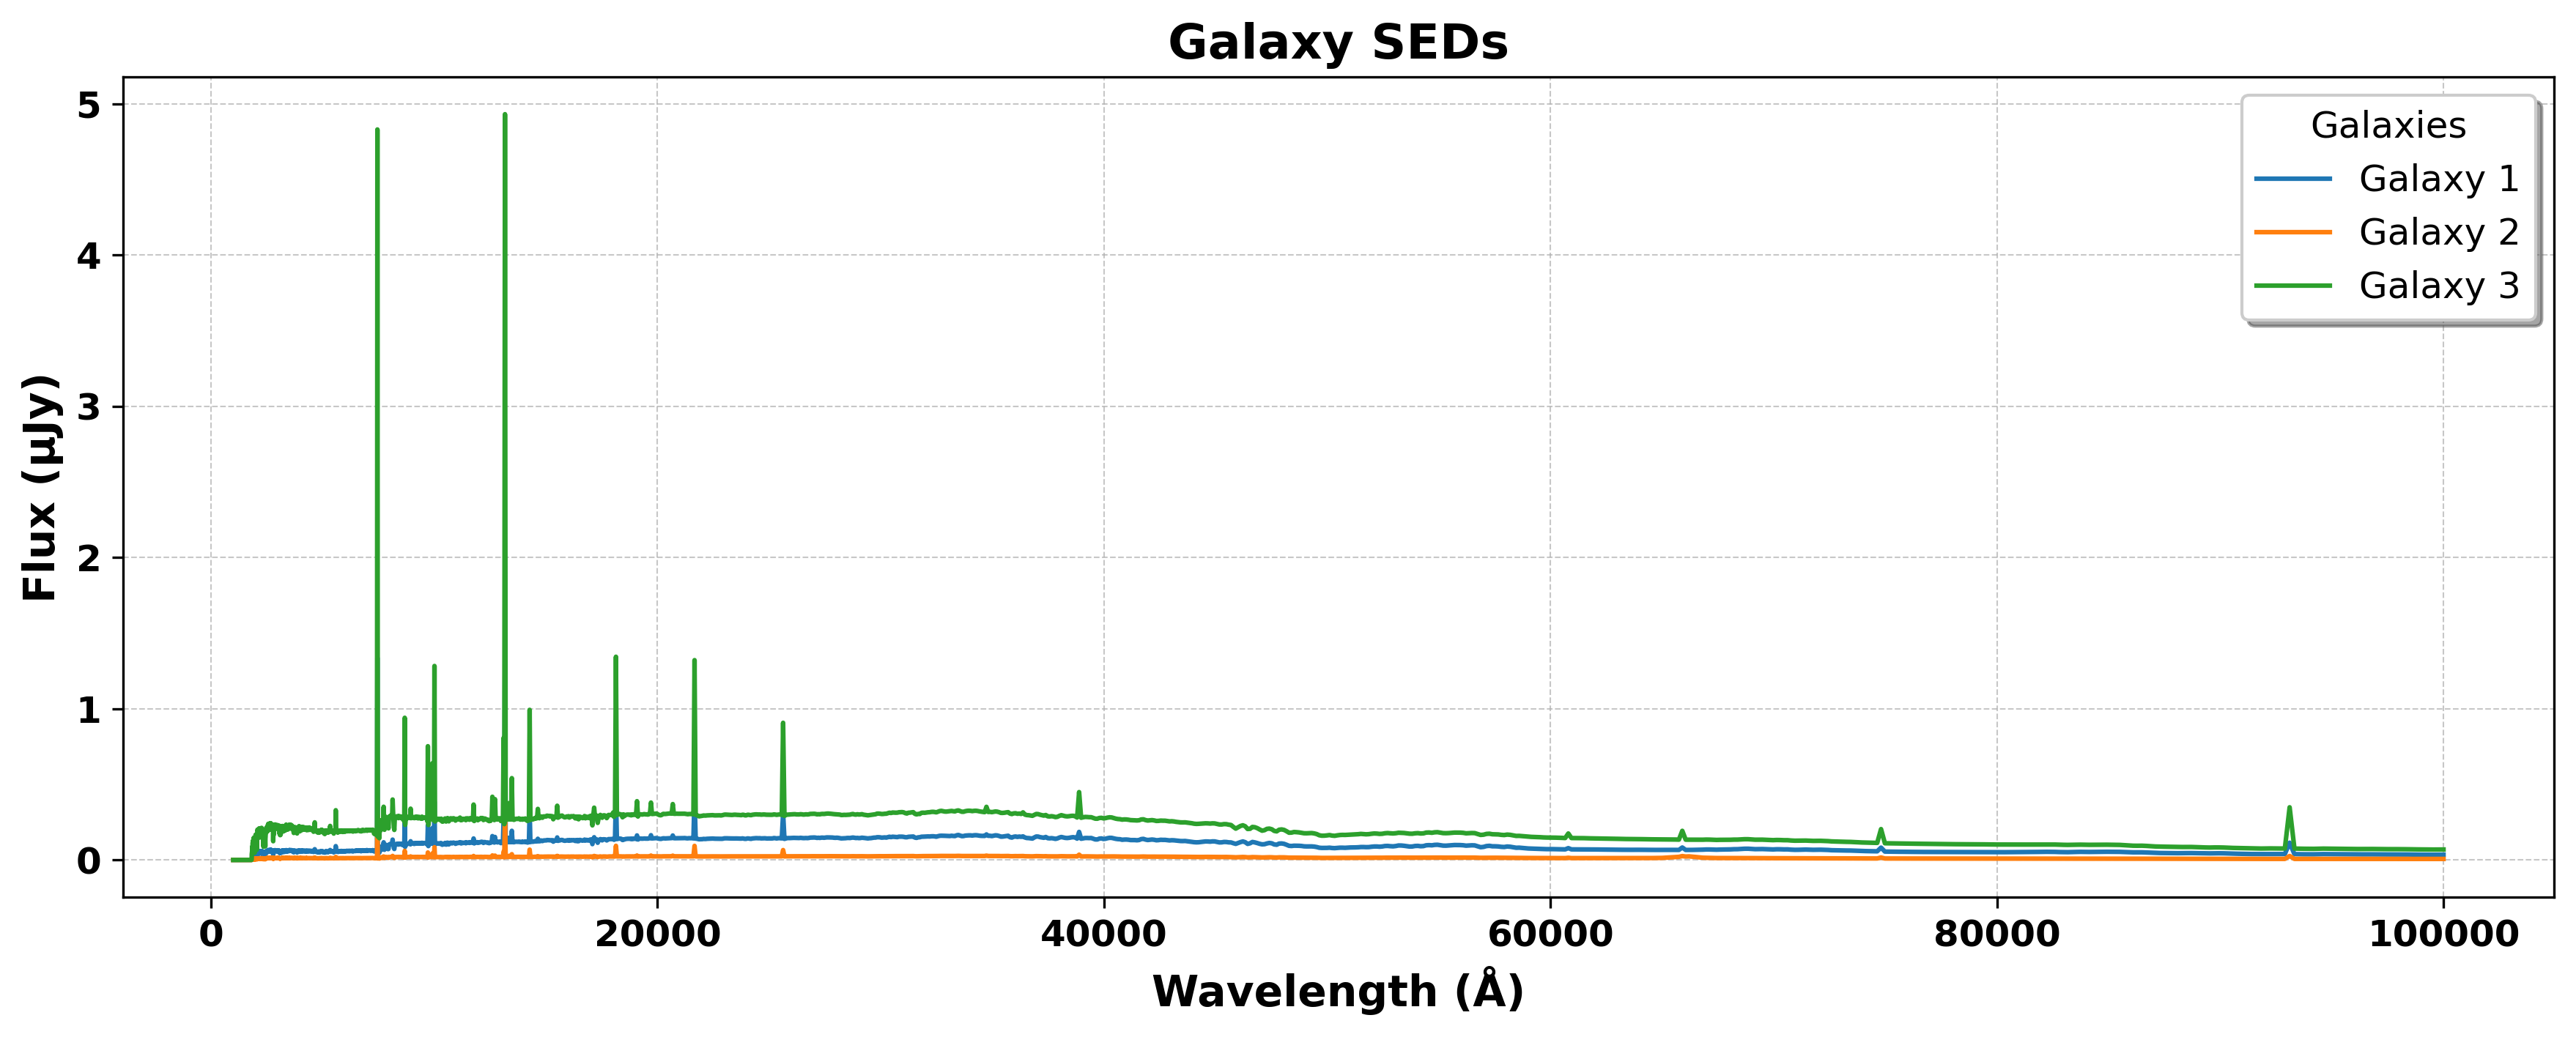

In [9]:
wavelens=np.logspace(3,5,2000)

galaxy1=features.iloc[0]
galaxy2=features.iloc[1]
galaxy3=features.iloc[2]


# Replot with the same data and axes, focusing on font and grid improvements
plt.figure(figsize=(12, 5))
plt.plot(wavelens, galaxy1, label='Galaxy 1')
plt.plot(wavelens, galaxy2, label='Galaxy 2')
plt.plot(wavelens, galaxy3, label='Galaxy 3')

# Enhancing plot appearance without changing axes or data
plt.xlabel('Wavelength (Å)', fontsize=14, weight='bold')
plt.ylabel('Flux (μJy)', fontsize=14, weight='bold')
plt.title('Galaxy SEDs', fontsize=16, weight='bold')
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(fontsize=12, loc='best', title='Galaxies', title_fontsize=12, frameon=True, shadow=True)
plt.tight_layout()

# Show the plot
plt.show()

## 2. Remove irrelevant features

Looking at these plots and the first few columns of the data we find that the flux is extremely tiny for the initial wavelengths. This is because the wavelengths corresponding to the Lyman limit (<912 angstroms in the rest frame and equivalently <1824 angstroms in the dataset corresponding to z=1) are completely absorbed. Given the extremely tiny flux, we can get rid of these columns as they don't contribute meaningfully to the analysis. This helps reduce the size of the dataset.

In [10]:
eliminate=features.columns.get_loc("1824")
eliminate
features.drop(features.iloc[:, 0:eliminate], inplace = True, axis = 1) 
features.head()

,1824,1828,1832,1837,1841,1845,1849,1854,1858,1862,1866,1871,1875,1879,1884,1888,1892,1897,1901,1906,1910,1914,1919,1923,1928,1932,1937,1941,1946,1950,1954,1959,1964,1968,1973,1977,1982,1986,1991,1995,2000,2005,2009,2014,2019,2023,2028,2033,2037,2042,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0.003774,0.010979,0.011936,0.013958,0.015453,0.014882,0.021688,0.020984,0.024919,0.019352,0.023444,0.031638,0.017881,0.033747,0.032004,0.032537,0.035662,0.023218,0.023704,0.038259,0.037336,0.040008,0.038132,0.038817,0.040409,0.039883,0.034907,0.027427,0.016939,0.019204,0.012896,0.023382,0.035947,0.037896,0.038107,0.035897,0.024083,0.036181,0.035361,0.040492,0.045976,0.044278,0.042928,0.044074,0.041569,0.043087,0.044816,0.045045,0.041744,0.038417,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,0.000709,0.002065,0.002246,0.002627,0.002910,0.002804,0.004088,0.003958,0.004702,0.003654,0.004426,0.005978,0.003382,0.006383,0.006053,0.006155,0.006754,0.004402,0.004496,0.007257,0.007081,0.007590,0.007236,0.007370,0.007676,0.007583,0.006643,0.005226,0.003231,0.003663,0.002461,0.004458,0.006854,0.007228,0.007269,0.006850,0.004599,0.006912,0.006760,0.007743,0.008794,0.008473,0.008219,0.008444,0.007973,0.008264,0.008601,0.008653,0.008027,0.007396,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,0.013749,0.040011,0.043499,0.050863,0.056312,0.054230,0.079028,0.076463,0.090798,0.070517,0.085403,0.115270,0.065157,0.122949,0.116573,0.118498,0.129914,0.084600,0.086371,0.139369,0.135964,0.145670,0.138818,0.141313,0.147110,0.145224,0.127138,0.099927,0.061724,0.069966,0.046973,0.085112,0.130816,0.137902,0.138634,0.130586,0.087616,0.131629,0.128654,0.147312,0.167247,0.161062,0.156148,0.160343,0.151284,0.156756,0.163066,0.163941,0.151971,0.139911,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,0.002965,0.008632,0.009391,0.010989,0.012176,0.011735,0.017117,0.016569,0.019691,0.015297,0.018567,0.025054,0.014155,0.026758,0.025413,0.025865,0.028335,0.018441,0.018838,0.030456,0.029769,0.031929,0.030459,0.031025,0.032317,0.031895,0.027910,0.021914,0.013530,0.015355,0.010320,0.018767,0.028891,0.030482,0.030689,0.028931,0.019413,0.029191,0.028539,0.032711,0.037171,0.035822,0.034748,0.035685,0.033649,0.034924,0.036334,0.036516,0.033831,0.031115,...,0.031324,0.031156,0.031461,0.031467,0.031253,0.030759,0.030316,0.030019,0.029775,0.029435,0.029280,0.029095,0.028877,0.029080,0.029217,0.029081,0.029081,0.029055,0.110630,0.028966,0.028719,0.028537,0.028490,0.028421,0.028718,0.029049,0.028914,0.028803,0.028738,0.028609,

Okay, after some preprocessing, we still have 1739 features which is an extremely large number and can be quite taxing computationally!


Can we reduce the dataset size while still preserving key information? But first let's run the algorithm on all data at least once.

# Test Output: Let's pick dust for the prediction parameter or label/output

In [11]:
target = df['dust_av']
target

0       0.001000
1       0.090474
2       0.001000
3       0.096450
4       0.001000
          ...   
1995    0.001000
1996    0.001000
1997    0.001000
1998    0.712737
1999    0.149430
Name: dust_av, Length: 2000, dtype: float64

# We pick Random Forest Regressor as the Machine Learning Algorithm

In [12]:
model = RandomForestRegressor()

# Print the settings of the model
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's do 5 fold Cross-Validation and compute the scores (scores are R2 scores).

In [13]:
scores = cross_validate(model,features,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([1066.36501956,  888.36830688,  884.77995062,  886.56170416,
        882.04974389]), 'score_time': array([0.0382731 , 0.02799869, 0.03095841, 0.02900386, 0.02803755]), 'test_score': array([0.95172939, 0.95753946, 0.93879489, 0.93921343, 0.91699495]), 'train_score': array([0.99150123, 0.99173311, 0.99150707, 0.99218341, 0.9925523 ])}
The Mean Test Score is 0.940854424914518
The Mean Train Score is 0.9918954245115248


So the Good news is that both the train and test scores are rather good!

But that took very long.

Let's try reducing the dataset.

There are many ways to do this. How about we try reducing the dataset by a factor of 10. This was done by finding the average of the flux in every ten consecutive data points (or columns) and saving this result in new columns which I call new1, new2, new3...new173.

Note: we will ignore the last 9 columns of the data set so we are taking the mean of every 10 columns for 1730 features and arrive at 173 features.

In [12]:
# Simulating the 'features' DataFrame (replace with actual data)
features = pd.DataFrame(np.random.rand(2000, 1730))  # Assuming enough columns

# Create a copy to avoid modifying the original data
test = features.copy()

i = 1
j = 0
step = 10

new_columns = []  # Store computed columns

while i <= 173:
    new_col = test.iloc[0:2000, j:j+step].mean(axis=1)  # Compute mean
    new_columns.append(new_col.rename(f'new{i}'))  # Store column with new name
    i += 1
    j += step

# Efficiently add all new columns at once
test = pd.concat([test] + new_columns, axis=1)

#test

The new columns are saved at the end. Let's get rid of the previous columns.

In [15]:
newfeatures=test.loc[:,'new1':]
newfeatures

,new1,new2,new3,new4,new5,new6,new7,new8,new9,new10,new11,new12,new13,new14,new15,new16,new17,new18,new19,new20,new21,new22,new23,new24,new25,new26,new27,new28,new29,new30,new31,new32,new33,new34,new35,new36,new37,new38,new39,new40,new41,new42,new43,new44,new45,new46,new47,new48,new49,new50,...,new124,new125,new126,new127,new128,new129,new130,new131,new132,new133,new134,new135,new136,new137,new138,new139,new140,new141,new142,new143,new144,new145,new146,new147,new148,new149,new150,new151,new152,new153,new154,new155,new156,new157,new158,new159,new160,new161,new162,new163,new164,new165,new166,new167,new168,new169,new170,new171,new172,new173
0,0.015793,0.029209,0.033306,0.032024,0.043193,0.040244,0.052435,0.052510,0.053157,0.052448,0.051973,0.046177,0.037228,0.055874,0.059772,0.060202,0.063531,0.061914,0.056031,0.062104,0.060148,0.060267,0.054975,0.051977,0.058719,0.057625,0.060254,0.059836,0.062342,0.062087,0.058571,0.058415,0.057588,0.057717,0.058577,0.060147,0.059005,0.059070,0.059143,0.058104,0.057782,0.053798,0.053725,0.055203,0.052584,0.054957,0.058105,0.055318,0.059709,0.056102,...,0.151302,0.154632,0.158630,0.160725,0.162050,0.158626,0.154078,0.148051,0.145353,0.150128,0.141810,0.140560,0.133748,0.132826,0.127511,0.119737,0.117780,0.113985,0.106653,0.094691,0.083286,0.081393,0.087507,0.091937,0.095723,0.096563,0.090917,0.082757,0.072585,0.070702,0.068339,0.066863,0.068101,0.068154,0.071922,0.069842,0.067189,0.061299,0.057839,0.052670,0.051809,0.051906,0.052905,0.053577,0.049825,0.045039,0.042106,0.046396,0.038038,0.036866
1,0.002976,0.005529,0.006330,0.006113,0.008284,0.007766,0.010146,0.010207,0.010378,0.010281,0.010229,0.009140,0.007422,0.011150,0.011968,0.012100,0.012794,0.012513,0.011345,0.012624,0.012251,0.012311,0.011251,0.010664,0.012064,0.011877,0.012439,0.012341,0.012848,0.012807,0.012115,0.012081,0.011938,0.011940,0.012154,0.012490,0.012266,0.012283,0.012302,0.012115,0.012072,0.011333,0.011300,0.011581,0.011097,0.011524,0.012008,0.011517,0.012609,0.011647,...,0.025218,0.025650,0.026300,0.026549,0.026759,0.026115,0.025477,0.024557,0.023998,0.025067,0.023299,0.023021,0.022097,0.021840,0.021065,0.020040,0.019609,0.018418,0.017125,0.015576,0.014061,0.013875,0.014632,0.015119,0.015508,0.015538,0.014824,0.013813,0.012583,0.012420,0.012049,0.012297,0.018831,0.015238,0.012283,0.011676,0.011198,0.010393,0.010256,0.009236,0.009055,0.008984,0.009042,0.009061,0.008489,0.007799,0.007370,0.008894,0.006894,0.006787
2,0.057547,0.106410,0.121285,0.116523,0.157173,0.146496,0.190671,0.190911,0.193189,0.190496,0.188715,0.167823,0.135509,0.202841,0.216689,0.218116,0.229693,0.223851,0.202244,0.224300,0.217009,0.217397,0.198118,0.187262,0.211155,0.207394,0.216567,0.213930,0.221847,0.220505,0.208125,0.206843,0.203956,0.203124,0.206363,0.211471,0.207203,0.206858,0.206541,0.202943,0.201702,0.189416,0.188136,0.191960,0.183872,0.189805,0.196100,0.187988,0.206172,0.188593,...,0.309771,0.313729,0.321270,0.323015,0.324812,0.316040,0.308868,0.297940,0.289911,0.304064,0.279556,0.275151,0.265110,0.260701,0.251741,0.241091,0.234760,0.215596,0.199091,0.183284,0.167433,0.165955,0.172808,0.176669,0.179355,0.178672,0.171364,0.161194,0.149320,0.147449,0.140958,0.137466,0.140972,0.133655,0.135000,0.131069,0.126298,0.118178,0.119590,0.106294,0.103609,0.101846,0.101445,0.100642,0.093680,0.085563,0.080134,0.102962,0.074049,0.072115
3,0.012456,0.023188,0.026610,0.025793,0.034980,0.032742,0.042989,0.043286,0.044063,0.043726,0.043562,0.038848,0.031374,0.047581,0.051171,0.051754,0.054915,0.053729,0.048860,0.054312,0.052806,0.053067,0.048568,0.046056,0.052141,0.051297,0.053728,0.053290,0.055498,0.055355,0.052343,0.052231,0.051652,0.051685,0.052584,0.054062,0.053099,0.053143,0.053210,0.052405,0.052177,0.049027,0.048890,0.050154,0.048085,0.049964,0.051949,0.049910,0.054606,0.050485,...,0.105228,0.106797,0.109483,0.110292,0.110960,0.108244,0.105736,0.102034,0.099477,0.103784,0.096334,0.095051,0.091507,0.090228,0.087125,0.083285,0.081350,0.075599,0.070130,0.064234,

Okay, let's test the results on the reduced dataset

In [16]:
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([84.26535988, 81.75105858, 81.25922751, 80.53299689, 79.89654732]), 'score_time': array([0.01399922, 0.01500988, 0.0150187 , 0.01496935, 0.0139997 ]), 'test_score': array([0.94637854, 0.94752707, 0.93012586, 0.93586497, 0.90155503]), 'train_score': array([0.98945893, 0.99121255, 0.99081842, 0.99086259, 0.99131027])}
The Mean Test Score is 0.932290293196087
The Mean Train Score is 0.9907325502965811


### Looks like the scores are more or less the same. They dropped ever so slightly but compared to the computational time we are saving (~ Factor 10) , this seems like a fair trade-off!

## Parameter Optimization

Evaluating the scores: They seem good, neither variance nor bias issues. 

Can we do better? Let's do a deep gridsearch and vary 4 hyperparameters.

In [17]:
parameters = {'max_depth':[3, 6, 10, None], \
              'max_features':[None,10,50,100], 'n_estimators':[50,200,400], 'min_samples_leaf': [1,5,10,50]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(random_state = 5), parameters, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                     verbose = 2, n_jobs = -1, return_train_score=True)
model.fit(newfeatures,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params, best score: 0.9343 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}


In [18]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
146,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}",0.934320,0.014938,0.990803
145,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.933814,0.014698,0.990739
182,"{'max_depth': None, 'max_features': 100, 'min_samples_leaf': 1, 'n_estimators': 400}",0.932280,0.014240,0.990432
98,"{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}",0.932174,0.014841,0.989178
181,"{'max_depth': None, 'max_features': 100, 'min_samples_leaf': 1, 'n_estimators': 200}",0.931933,0.014381,0.990325
...,...,...,...,...
35,"{'max_depth': 3, 'max_features': 50, 'min_samples_leaf': 50, 'n_estimators': 400}",0.599959,0.041696,0.624133
34,"{'max_depth': 3, 'max_features': 50, 'min_samples_leaf': 50, 'n_estimators': 200}",0.599069,0.039617,0.622675
23,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 400}",0.538233,0.045047,0.565945
21,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 50}",0.536928,0.050751,0.566144


### So it looks like parameter optimization does not really help (best test score: 0.934)

### Alright let's do all the above for Stellar Mass


In [ ]:
target = df['mass']
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The scores are {'fit_time': array([78.30268073, 77.93715382, 78.01792002, 77.64979982, 78.81415749]), 'score_time': array([0.01600194, 0.01701474, 0.0150032 , 0.01600218, 0.01400781]), 'test_score': array([0.98050683, 0.97404305, 0.97843346, 0.9771216 , 0.97946225]), 'train_score': array([0.99703246, 0.99712315, 0.99698263, 0.99682109, 0.99693685])}
The Mean Test Score is 0.9779134374899788
The Mean Train Score is 0.9969792377073228


#### Great scores. I tried optimization but that did not improve the scores significantly just like in the previous case.

#### Alright. What about our final two parameters Age of the galaxy and the parameter Tau? Let's go through the same drill for age first.

In [20]:
target = df['age']
target

0       1.448590
1       0.955411
2       0.663121
3       0.676862
4       1.198344
          ...   
1995    1.316113
1996    0.615126
1997    0.518917
1998    0.400563
1999    0.791157
Name: age, Length: 2000, dtype: float64

In [21]:
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([95.550102  , 96.78902698, 91.29564953, 90.57025409, 92.72139168]), 'score_time': array([0.01700735, 0.01600075, 0.01812267, 0.01699567, 0.01700997]), 'test_score': array([0.60489405, 0.54580422, 0.58019578, 0.53597501, 0.58920513]), 'train_score': array([0.93846762, 0.93892173, 0.93638451, 0.93852468, 0.9382444 ])}
The Mean Test Score is 0.5712148380086056
The Mean Train Score is 0.9381085882020053


The train scores seemed fine but the test scores were pretty bad and we have some real variance issues.

Well what about Tau?

In [22]:
target = df['tauGyr']
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([103.18406892, 100.82759762, 104.74510717, 100.59927273,
        99.37159991]), 'score_time': array([0.01895595, 0.0160284 , 0.01595259, 0.01600695, 0.01504087]), 'test_score': array([ 0.13809886,  0.116516  ,  0.07182552, -0.03534014,  0.1424598 ]), 'train_score': array([0.87121081, 0.86862185, 0.87221491, 0.87130456, 0.87033205])}
The Mean Test Score is 0.08671200966370052
The Mean Train Score is 0.8707368359455246


# Feature Engineering

The scores are horrendous and we have some work to do. Maybe we could try Parameter Optimization? Yes, but that did not work either. 

One way to improve the features is to maybe do some sort of feature engineering. 

Instead of working directly with the Age and the Tau, let's instead take the logarithms and see what happens.

In [23]:
target = df['age']
target=np.log(target)
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([95.55334067, 98.72845674, 93.26256895, 93.88737106, 96.68659997]), 'score_time': array([0.020998  , 0.0170002 , 0.01499701, 0.01500535, 0.0170033 ]), 'test_score': array([0.70034322, 0.68570449, 0.63810767, 0.71059935, 0.72807592]), 'train_score': array([0.95814835, 0.95677413, 0.95670417, 0.95759689, 0.95503745])}
The Mean Test Score is 0.6925661308518044
The Mean Train Score is 0.9568521984974453


### That was very helpful! Let's do the same for Tau

In [ ]:
target = df['tauGyr']
target=np.log(target)

model = RandomForestRegressor()

scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([96.29888058, 93.36139846, 96.36937022, 98.01139808, 92.22386098]), 'score_time': array([0.01700068, 0.01700807, 0.01994562, 0.01499915, 0.01599693]), 'test_score': array([0.63867504, 0.56326998, 0.58753015, 0.61283843, 0.64471317]), 'train_score': array([0.94476585, 0.94663376, 0.94766096, 0.94558293, 0.94244546])}
The Mean Test Score is 0.6094053515986939
The Mean Train Score is 0.9454177911616016


Wow, that was a significant improvement!

We might as well take the log of the input and see if that helps too.

In [25]:
target = df['age']
target=np.log(target)
newfeatures2=np.log(newfeatures)
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures2,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([ 95.85758853, 100.7473495 ,  92.55811477,  94.47145772,
        97.63801646]), 'score_time': array([0.01595616, 0.01499867, 0.01600432, 0.01599503, 0.01699924]), 'test_score': array([0.68614165, 0.68322808, 0.63935113, 0.70650326, 0.73170579]), 'train_score': array([0.95557333, 0.95772355, 0.95697288, 0.95677124, 0.95616294])}
The Mean Test Score is 0.6893859835219333
The Mean Train Score is 0.9566407886926566


### That did not help really

### Let's try the same for tau

In [26]:
target = df['tauGyr']
target=np.log(target)
newfeatures2=np.log(newfeatures)
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures2,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([95.42893028, 92.56851029, 94.38423991, 94.28934264, 92.43631244]), 'score_time': array([0.01600146, 0.01502419, 0.01699972, 0.01599884, 0.01901388]), 'test_score': array([0.64701283, 0.5639139 , 0.59898391, 0.60703152, 0.65372643]), 'train_score': array([0.94439824, 0.9478823 , 0.94693179, 0.9470036 , 0.94522013])}
The Mean Test Score is 0.6141337157656276
The Mean Train Score is 0.9462872103597079


Okay did not really help. I also tried taking the logarithm of the features and keeping the targets normal but the scores in that case were quite bad. So the best improvement was found by simply taking the logarithm of the targets alone. But there is still room for improvement. Can we try optimizing for Age and Tau with their new logarithmic values?

In [27]:
#Parameter Optimization

target = df['age']
target=np.log(target)

parameters = {'max_depth':[3, 6, 10, None], \
              'max_features':[None,10,50,100], 'n_estimators':[50,200,400], 'min_samples_leaf': [1,5,10,50]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(random_state = 5), parameters, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                     verbose = 2, n_jobs = -1, return_train_score=True)
model.fit(newfeatures,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params, best score: 0.6928 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}


In [28]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score
146,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}",0.692783,0.032157,0.958301
145,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 200}",0.691564,0.032119,0.957747
182,"{'max_depth': None, 'max_features': 100, 'min_samples_leaf': 1, 'n_estimators': 400}",0.688450,0.031058,0.957609
144,"{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 50}",0.686714,0.031456,0.953399
181,"{'max_depth': None, 'max_features': 100, 'min_samples_leaf': 1, 'n_estimators': 200}",0.685404,0.032791,0.957159
...,...,...,...,...
19,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 10, 'n_estimators': 200}",0.106056,0.016807,0.155962
23,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 400}",0.105010,0.009498,0.143614
22,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 50, 'n_estimators': 200}",0.104262,0.009515,0.143205
18,"{'max_depth': 3, 'max_features': 10, 'min_samples_leaf': 10, 'n_estimators': 50}",0.102860,0.019914,0.151767


And the same for Tau

In [29]:
#Parameter Optimization

target = df['tauGyr']
target=np.log(target)

parameters = {'max_depth':[3, 6, 10, None], \
              'max_features':[None,10,50,100], 'n_estimators':[50,200,400], 'min_samples_leaf': [1,5,10,50]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(RandomForestRegressor(random_state = 5), parameters, cv = KFold(n_splits=5, shuffle=True, random_state=10), \
                     verbose = 2, n_jobs = -1, return_train_score=True)
model.fit(newfeatures,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params, best score: 0.6174 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 400}


## Adding more Data

- Okay after a laborious wait, it appears that parameter optimization does not help. I also tried using a large number of estimators (1000), but the results were the same. We will have to think of something else. 

- How about adding more data? We can look at our learning set and analyze if we have enough data. We do this by plotting the learning curves and check if scores are improving with increasing data.

## Plotting Learning Curve for Age

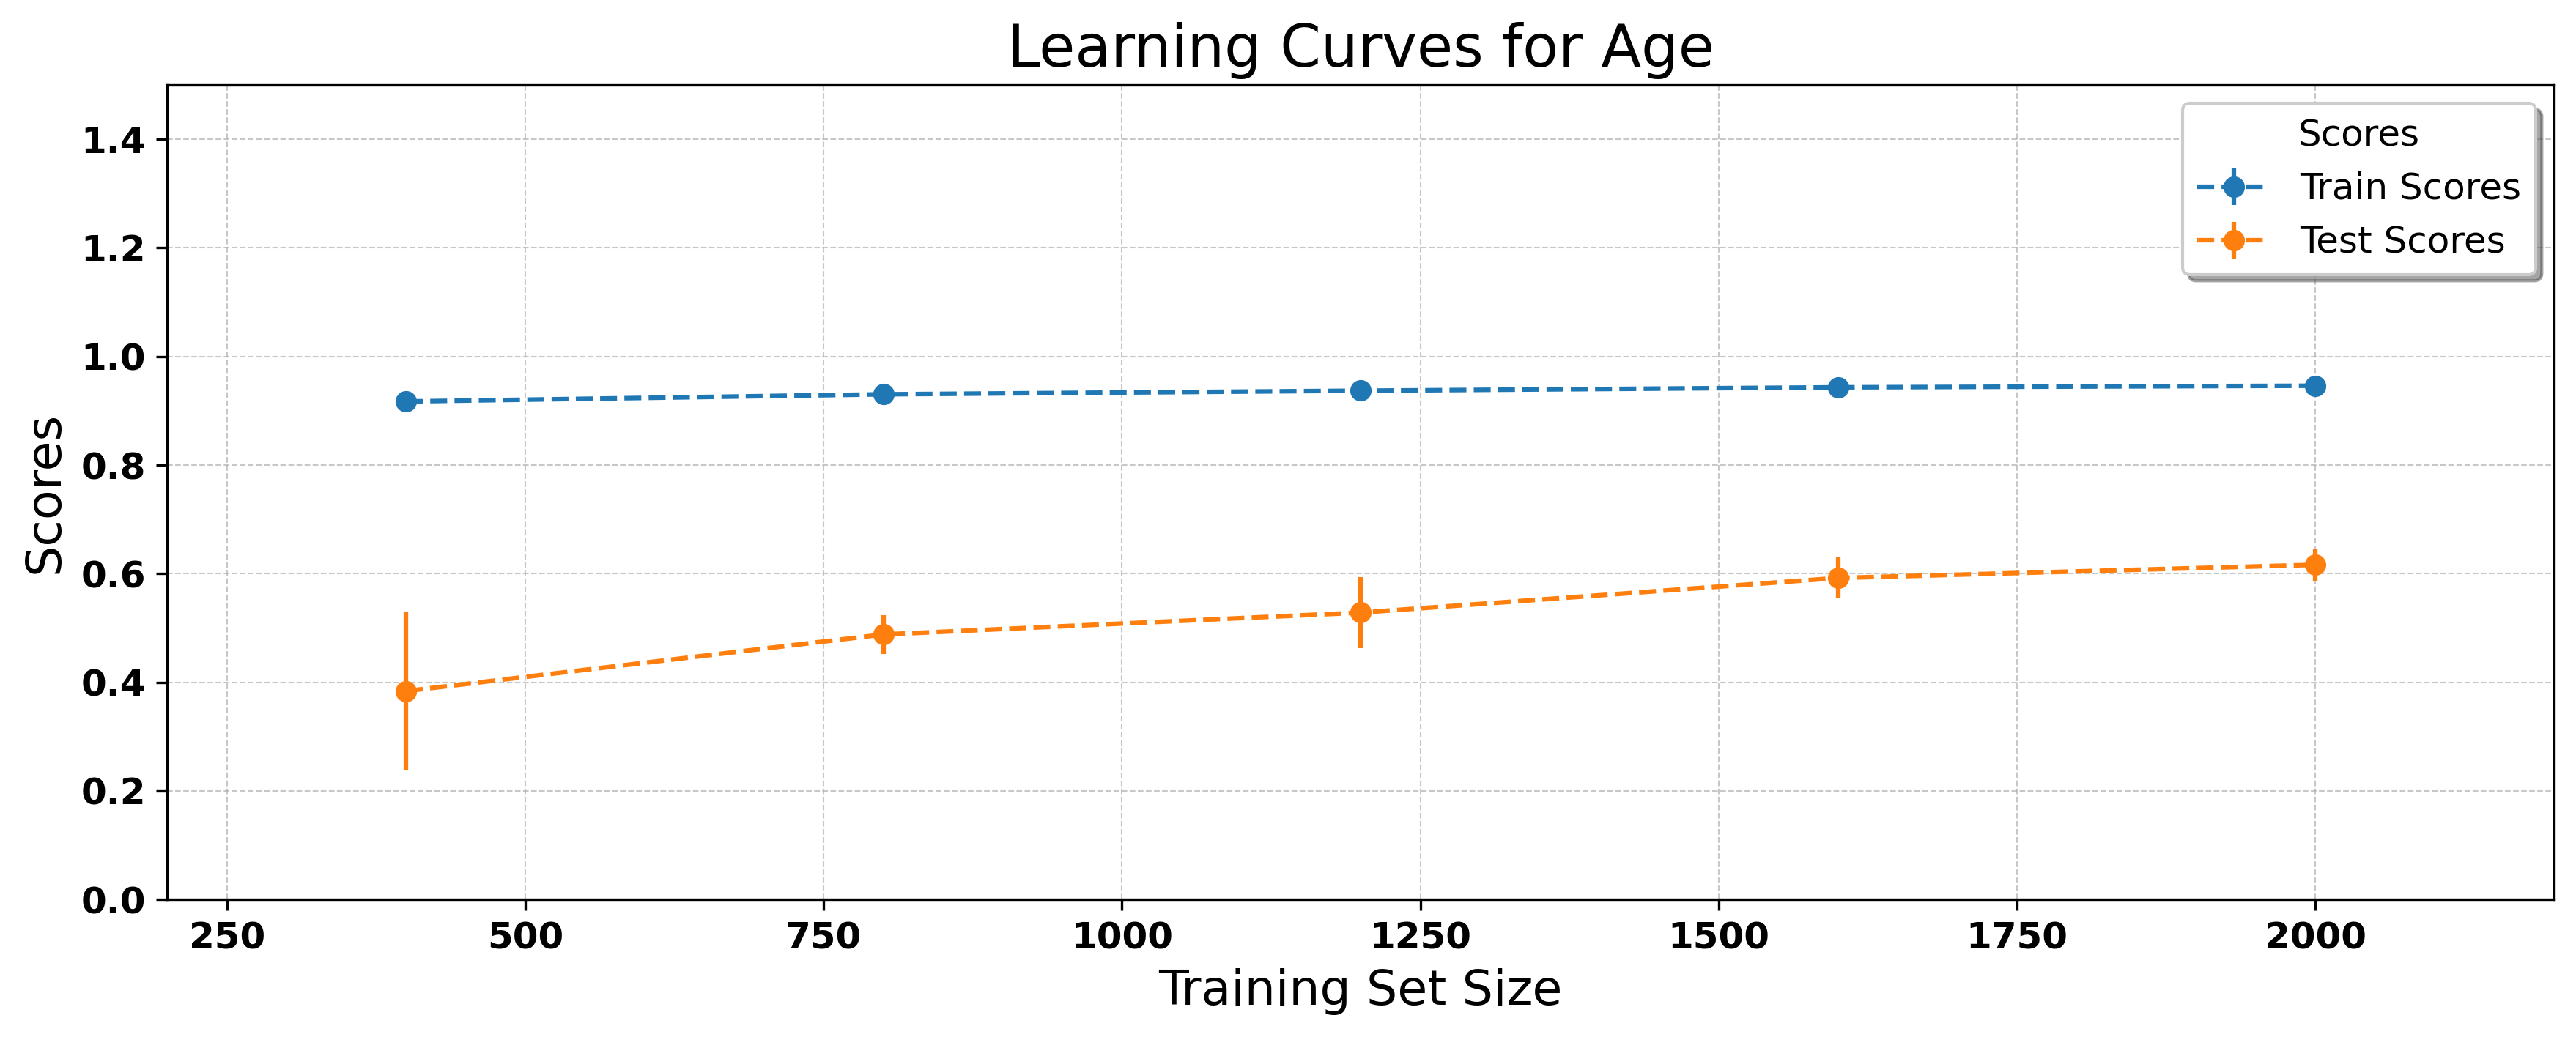

In [76]:
#Learning Curves

trainscores=[]
trainstd=[]
testscores=[]
teststd=[]

target = df['age']
# Transform target variable
target = np.log(df['age'])

# Define training set sizes
TrainingSet = [400, 800, 1200, 1600, 2000]

for size in TrainingSet:
    final_features = newfeatures.iloc[0:size]
    targets = target.iloc[0:size]
    
    model = RandomForestRegressor()
    model.get_params()
    
    scores3 = cross_validate(
        model, final_features, targets, 
        cv=KFold(n_splits=5, shuffle=True, random_state=10), 
        return_train_score=True
    )
    
    testscores.append(scores3['test_score'].mean())
    teststd.append(scores3['test_score'].std())
    
    trainscores.append(scores3['train_score'].mean())
    trainstd.append(scores3['train_score'].std())



# Plot Learning Curve
plt.figure(figsize=(12, 5))
plt.title('Learning Curves for Age')
plt.xlabel('Training Set Size')
plt.ylabel('Scores')

plt.errorbar(TrainingSet, trainscores, yerr=trainstd, fmt='--o', label='Train Scores')
plt.errorbar(TrainingSet, testscores, yerr=teststd, fmt='--o', label='Test Scores')

plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.xlim(200, 2200)
plt.ylim(0.0, 1.5)

plt.legend(fontsize=12, loc='best', title='Scores', title_fontsize=12, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

### Learning Curves for Tau

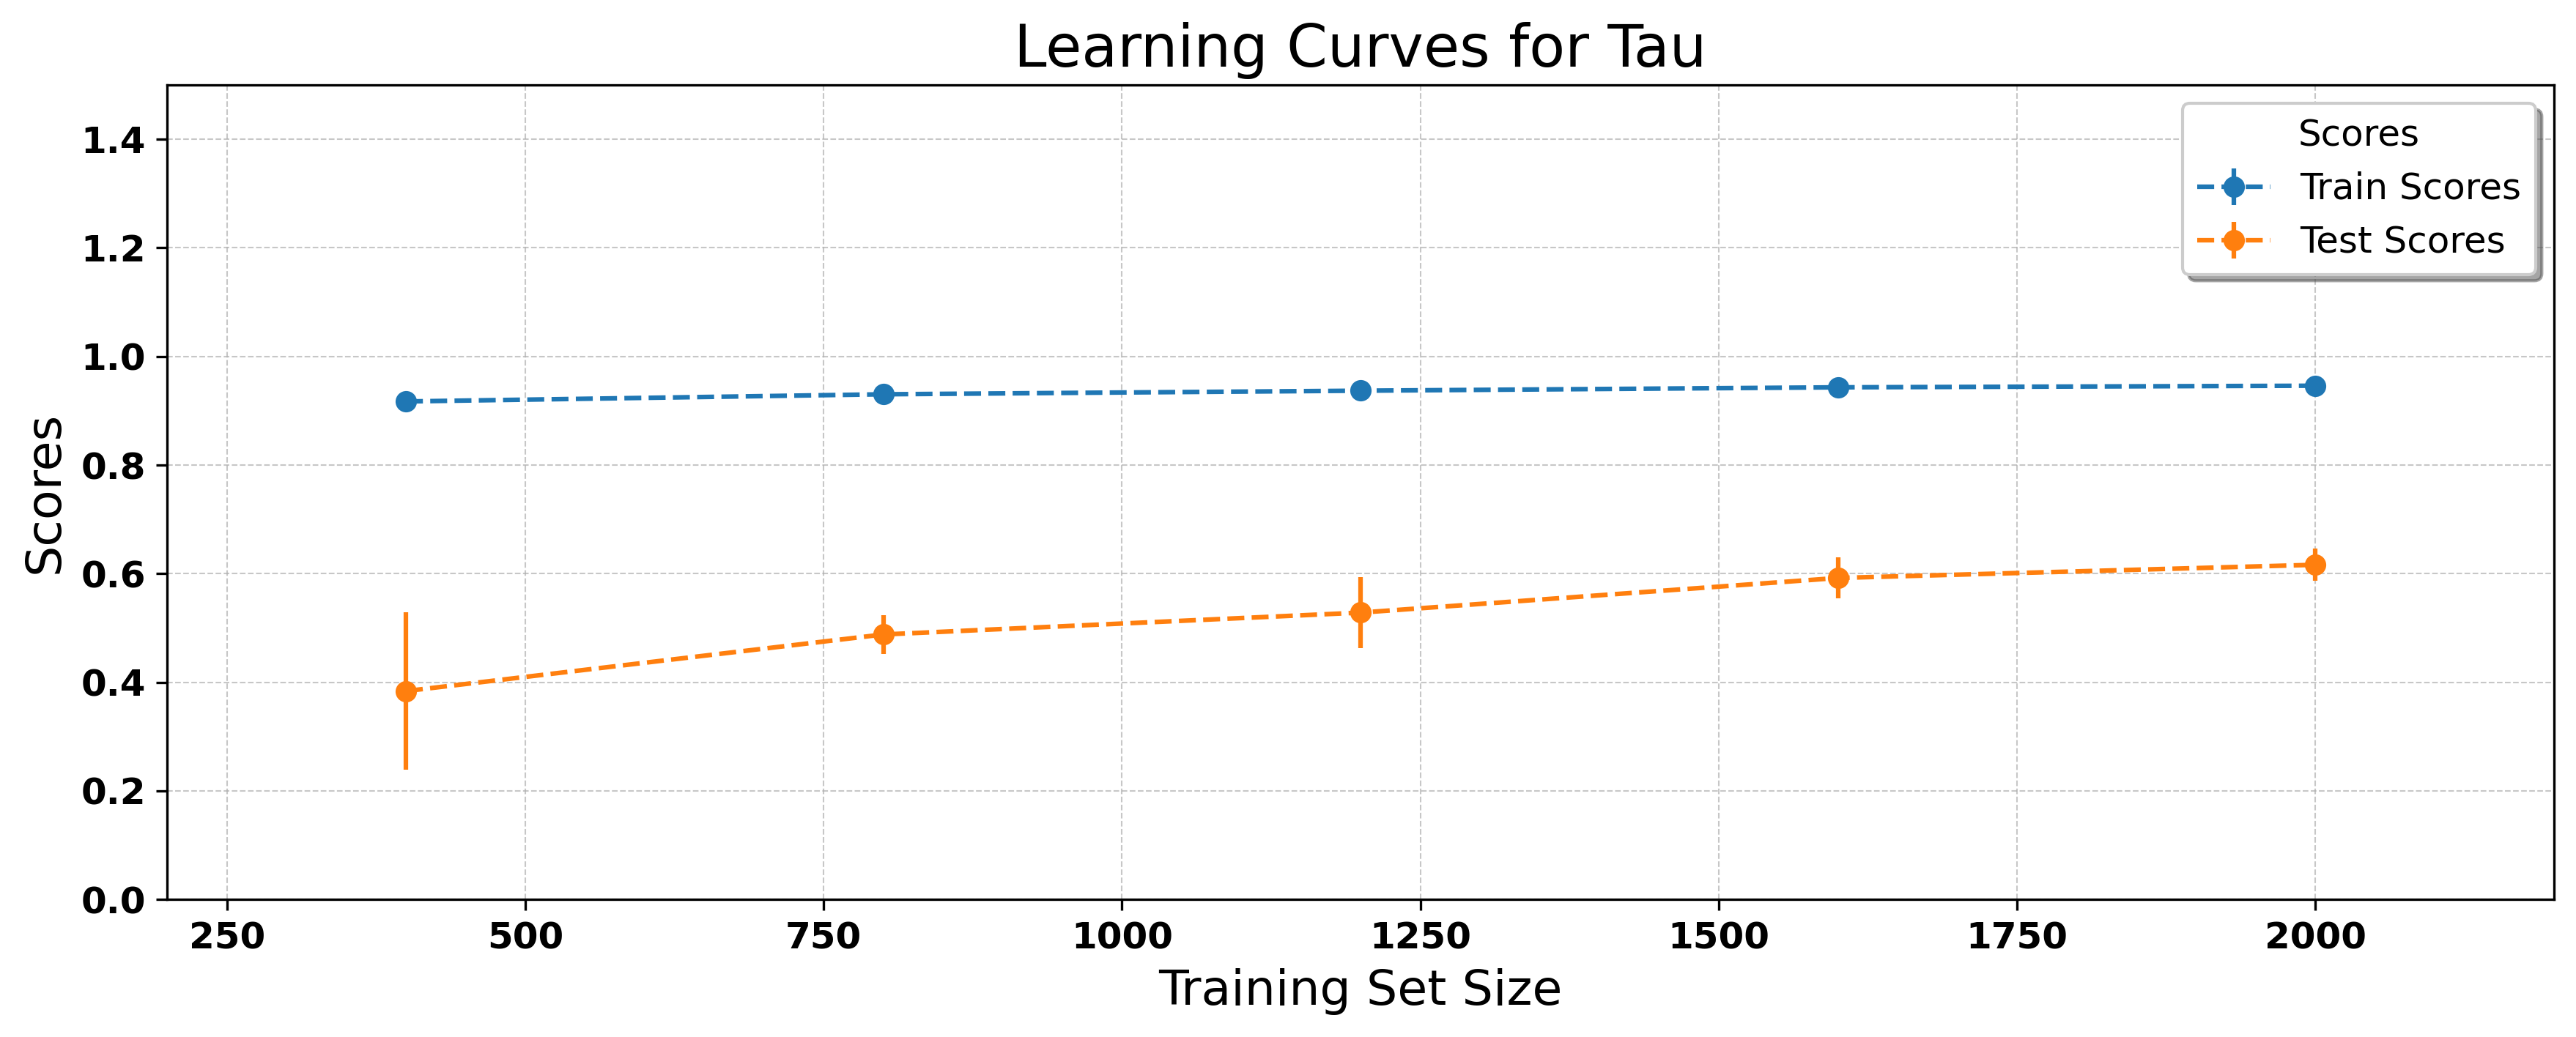

In [ ]:
#Learning Curves

trainscores=[]
trainstd=[]
testscores=[]
teststd=[]

target = df['tauGyr']
# Transform target variable
target = np.log(df['tauGyr'])

# Define training set sizes
TrainingSet = [400, 800, 1200, 1600, 2000]

for size in TrainingSet:
    final_features = newfeatures.iloc[0:size]
    targets = target.iloc[0:size]
    
    model = RandomForestRegressor()
    model.get_params()
    
    scores3 = cross_validate(
        model, final_features, targets, 
        cv=KFold(n_splits=5, shuffle=True, random_state=10), 
        return_train_score=True
    )
    
    testscores.append(scores3['test_score'].mean())
    teststd.append(scores3['test_score'].std())
    
    trainscores.append(scores3['train_score'].mean())
    trainstd.append(scores3['train_score'].std())



# Plot Learning Curve
plt.figure(figsize=(12, 5))
plt.title('Learning Curves for Tau')
plt.xlabel('Training Set Size')
plt.ylabel('Scores')

plt.errorbar(TrainingSet, trainscores, yerr=trainstd, fmt='--o', label='Train Scores')
plt.errorbar(TrainingSet, testscores, yerr=teststd, fmt='--o', label='Test Scores')

plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.xlim(200, 2200)
plt.ylim(0.0, 1.5)

plt.legend(fontsize=12, loc='best', title='Scores', title_fontsize=12, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

### Part 2: Dataset of 4000 Galaxies

The scores seem to keep rising with increasing data; although the rate of improvement is diminishing. However it seems like it might be worthwhile to look at some more data because we can take any improvements for Age and Tau as a win. So We added 2000 more galaxies to the data. Let's do the same drill over again, starting with data preprocessing and then proceed from there to compute the scores with Random Forests.

In [13]:
df1=pd.read_csv("goodss_3dhst_mock_final_2020_11_30.dat")
df1

,Unnamed: 0,dust_av,z,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0,0.001000,1,1.448590,8.285529,0.678935,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,1,0.090474,1,0.955411,7.380163,0.661996,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,2,0.001000,1,0.663121,8.376067,0.458381,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,3,0.096450,1,0.676862,7.957642,0.345218,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.334115e-06,1.244197e-06,1.341927e-06,1.531180e-06,1.408585e-06,1.358868e

In [14]:
df2=pd.read_csv("goodss_3dhst_mock_final_2020_12_11.dat")
df2

,Unnamed: 0,dust_av,z,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0,1.205492,1,1.566348,10.119259,0.245109,2.124242e-07,2.151625e-07,2.127881e-07,2.196632e-07,2.246611e-07,2.305009e-07,2.304675e-07,2.381644e-07,2.449699e-07,2.508437e-07,2.508402e-07,2.579507e-07,2.655033e-07,2.633882e-07,2.625786e-07,2.655315e-07,2.647999e-07,2.716533e-07,2.752644e-07,2.772820e-07,2.872788e-07,2.883920e-07,2.760859e-07,2.896060e-07,2.931299e-07,2.928097e-07,3.079239e-07,3.076597e-07,3.131880e-07,3.116582e-07,3.170121e-07,3.070814e-07,3.126695e-07,3.262597e-07,3.294288e-07,3.275867e-07,3.356883e-07,3.406025e-07,3.467222e-07,3.490001e-07,3.410958e-07,3.598670e-07,3.548795e-07,3.445788e-07,...,2.280491,2.270604,2.309281,2.318524,2.302051,2.242687,2.192482,2.136798,2.083917,2.030883,2.012252,2.011300,1.996272,2.012347,2.024769,2.017350,2.029966,2.034281,2.417347,2.019298,1.978127,1.950883,1.951038,1.947424,1.987178,2.032782,2.019575,2.009903,2.001563,1.982836,1.974125,1.954699,1.944567,1.950211,1.957277,1.956905,1.941144,1.937474,1.932756,1.938176,1.941229,1.924004,1.927678,1.921101,1.884980,1.869546,1.859816,1.844261,1.874621,1.888958
1,1,0.050276,1,2.697541,8.266799,4.681428,1.376771e-06,1.382658e-06,1.350751e-06,1.387963e-06,1.498407e-06,1.746980e-06,1.848785e-06,1.918523e-06,2.169546e-06,2.325410e-06,2.217710e-06,2.337132e-06,2.557855e-06,2.408002e-06,2.342135e-06,2.323498e-06,2.215469e-06,2.321698e-06,2.248201e-06,2.189531e-06,2.607434e-06,2.578605e-06,2.281007e-06,2.473937e-06,2.422316e-06,2.384194e-06,2.695491e-06,2.623975e-06,2.643135e-06,2.580978e-06,2.605381e-06,2.251807e-06,2.388109e-06,2.632133e-06,2.697109e-06,2.629488e-06,2.702276e-06,2.753676e-06,2.825155e-06,2.842039e-06,2.669979e-06,3.003199e-06,2.858679e-06,2.757036e-06,...,0.039340,0.039121,0.039604,0.039657,0.039363,0.038562,0.037865,0.037244,0.036682,0.036044,0.035782,0.035610,0.035321,0.035574,0.035750,0.035576,0.035643,0.035636,0.108876,0.035436,0.034945,0.034598,0.034540,0.034438,0.034923,0.035470,0.035250,0.035072,0.034943,0.034694,0.034553,0.034266,0.034070,0.034164,0.034290,0.034221,0.033968,0.033855,0.033753,0.033794,0.033781,0.033527,0.033530,0.033414,0.032943,0.032730,0.032620,0.032398,0.032670,0.032805
2,2,0.001000,1,0.161881,7.514924,0.288634,3.009142e-07,3.137630e-07,3.133808e-07,3.451337e-07,7.196060e-07,1.629487e-06,2.103896e-06,2.255056e-06,3.157301e-06,3.702767e-06,3.335521e-06,3.709673e-06,4.480274e-06,3.997563e-06,3.820474e-06,3.744170e-06,3.389882e-06,3.726125e-06,3.415856e-06,3.201885e-06,4.712895e-06,4.641268e-06,3.780292e-06,4.325530e-06,4.111375e-06,4.029456e-06,5.021800e-06,4.807878e-06,4.839148e-06,4.686245e-06,4.739030e-06,3.590017e-06,4.084119e-06,4.859269e-06,5.121044e-06,4.948659e-06,5.148201e-06,5.323538e-06,5.559043e-06,5.645366e-06,5.163914e-06,6.216314e-06,5.788541e-06,5.614830e-06,...,0.030657,0.030354,0.030419,0.030324,0.030115,0.029876,0.029639,0.029665,0.029741,0.029669,0.029572,0.029282,0.029071,0.029218,0.029294,0.029127,0.028997,0.028921,0.245129,0.028893,0.028839,0.028752,0.028644,0.028536,0.028613,0.028686,0.028561,0.028441,0.028385,0.028324,0.028253,0.028137,0.027996,0.028067,0.028169,0.028068,0.027946,0.027821,0.027744,0.027726,0.027656,0.027563,0.027507,0.027447,0.027349,0.027301,0.027333,0.027276,0.027172,0.027152
3,3,0.121190,1,1.562569,8.868527,1.422105,3.805031e-06,3.828858e-06,3.735949e-06,3.856918e-06,4.278151e-06,5.237124e-06,5.655404e-06,5.903239e-06,6.870941e-06,7.471007e-06,7.068420e-06,7.518892e-06,8.368061e-06,7.809806e-06,7.574593

In [15]:
df1 = df1.drop(df1.columns[0], axis=1)
df1 = df1.drop(df1.columns[1], axis=1)
print("Initial Required Data")
df1.head()

Initial Required Data


,dust_av,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0.001000,1.448590,8.285529,0.678935,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,0.090474,0.955411,7.380163,0.661996,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,0.001000,0.663121,8.376067,0.458381,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,0.096450,0.676862,7.957642,0.345218,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.334115e-06,1.

In [16]:
df2 = df2.drop(df2.columns[0], axis=1)
df2 = df2.drop(df2.columns[1], axis=1)
print("Initial Required Data")
df2.head()

Initial Required Data


,dust_av,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,1.205492,1.566348,10.119259,0.245109,2.124242e-07,2.151625e-07,2.127881e-07,2.196632e-07,2.246611e-07,2.305009e-07,2.304675e-07,2.381644e-07,2.449699e-07,2.508437e-07,2.508402e-07,2.579507e-07,2.655033e-07,2.633882e-07,2.625786e-07,2.655315e-07,2.647999e-07,2.716533e-07,2.752644e-07,2.772820e-07,2.872788e-07,2.883920e-07,2.760859e-07,2.896060e-07,2.931299e-07,2.928097e-07,3.079239e-07,3.076597e-07,3.131880e-07,3.116582e-07,3.170121e-07,3.070814e-07,3.126695e-07,3.262597e-07,3.294288e-07,3.275867e-07,3.356883e-07,3.406025e-07,3.467222e-07,3.490001e-07,3.410958e-07,3.598670e-07,3.548795e-07,3.445788e-07,3.321447e-07,3.257740e-07,...,2.280491,2.270604,2.309281,2.318524,2.302051,2.242687,2.192482,2.136798,2.083917,2.030883,2.012252,2.011300,1.996272,2.012347,2.024769,2.017350,2.029966,2.034281,2.417347,2.019298,1.978127,1.950883,1.951038,1.947424,1.987178,2.032782,2.019575,2.009903,2.001563,1.982836,1.974125,1.954699,1.944567,1.950211,1.957277,1.956905,1.941144,1.937474,1.932756,1.938176,1.941229,1.924004,1.927678,1.921101,1.884980,1.869546,1.859816,1.844261,1.874621,1.888958
1,0.050276,2.697541,8.266799,4.681428,1.376771e-06,1.382658e-06,1.350751e-06,1.387963e-06,1.498407e-06,1.746980e-06,1.848785e-06,1.918523e-06,2.169546e-06,2.325410e-06,2.217710e-06,2.337132e-06,2.557855e-06,2.408002e-06,2.342135e-06,2.323498e-06,2.215469e-06,2.321698e-06,2.248201e-06,2.189531e-06,2.607434e-06,2.578605e-06,2.281007e-06,2.473937e-06,2.422316e-06,2.384194e-06,2.695491e-06,2.623975e-06,2.643135e-06,2.580978e-06,2.605381e-06,2.251807e-06,2.388109e-06,2.632133e-06,2.697109e-06,2.629488e-06,2.702276e-06,2.753676e-06,2.825155e-06,2.842039e-06,2.669979e-06,3.003199e-06,2.858679e-06,2.757036e-06,2.876403e-06,2.683092e-06,...,0.039340,0.039121,0.039604,0.039657,0.039363,0.038562,0.037865,0.037244,0.036682,0.036044,0.035782,0.035610,0.035321,0.035574,0.035750,0.035576,0.035643,0.035636,0.108876,0.035436,0.034945,0.034598,0.034540,0.034438,0.034923,0.035470,0.035250,0.035072,0.034943,0.034694,0.034553,0.034266,0.034070,0.034164,0.034290,0.034221,0.033968,0.033855,0.033753,0.033794,0.033781,0.033527,0.033530,0.033414,0.032943,0.032730,0.032620,0.032398,0.032670,0.032805
2,0.001000,0.161881,7.514924,0.288634,3.009142e-07,3.137630e-07,3.133808e-07,3.451337e-07,7.196060e-07,1.629487e-06,2.103896e-06,2.255056e-06,3.157301e-06,3.702767e-06,3.335521e-06,3.709673e-06,4.480274e-06,3.997563e-06,3.820474e-06,3.744170e-06,3.389882e-06,3.726125e-06,3.415856e-06,3.201885e-06,4.712895e-06,4.641268e-06,3.780292e-06,4.325530e-06,4.111375e-06,4.029456e-06,5.021800e-06,4.807878e-06,4.839148e-06,4.686245e-06,4.739030e-06,3.590017e-06,4.084119e-06,4.859269e-06,5.121044e-06,4.948659e-06,5.148201e-06,5.323538e-06,5.559043e-06,5.645366e-06,5.163914e-06,6.216314e-06,5.788541e-06,5.614830e-06,6.345959e-06,5.740605e-06,...,0.030657,0.030354,0.030419,0.030324,0.030115,0.029876,0.029639,0.029665,0.029741,0.029669,0.029572,0.029282,0.029071,0.029218,0.029294,0.029127,0.028997,0.028921,0.245129,0.028893,0.028839,0.028752,0.028644,0.028536,0.028613,0.028686,0.028561,0.028441,0.028385,0.028324,0.028253,0.028137,0.027996,0.028067,0.028169,0.028068,0.027946,0.027821,0.027744,0.027726,0.027656,0.027563,0.027507,0.027447,0.027349,0.027301,0.027333,0.027276,0.027172,0.027152
3,0.121190,1.562569,8.868527,1.422105,3.805031e-06,3.828858e-06,3.735949e-06,3.856918e-06,4.278151e-06,5.237124e-06,5.655404e-06,5.903239e-06,6.870941e-06,7.471007e-06,7

### Merge the two datasets

In [17]:
df = pd.concat([df1, df2], ignore_index=True)
df

,dust_av,age,mass,tauGyr,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0.001000,1.448590,8.285529,0.678935,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,0.090474,0.955411,7.380163,0.661996,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,0.001000,0.663121,8.376067,0.458381,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,0.096450,0.676862,7.957642,0.345218,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.334115e-06,1.

In [18]:
features=df
features = features.drop(features.columns[0], axis=1)
features= features.drop(features.columns[0], axis=1)
features = features.drop(features.columns[0], axis=1)
features = features.drop(features.columns[0], axis=1)
features.head()

,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,1111,1114,1116,1119,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,3.965901e-06,4.231984e-06,4.323793e-06,4.515295e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,4.858987e-07,5.194721e-07,5.318173e-07,5.588296e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,1.010177e-05,1.078340e-05,1.103210e-05,1.159777e-05,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.33411

In [19]:
features

,1000,1002,1004,1006,1009,1011,1013,1016,1018,1020,1023,1025,1028,1030,1032,1035,1037,1039,1042,1044,1047,1049,1051,1054,1056,1059,1061,1064,1066,1069,1071,1074,1076,1078,1081,1083,1086,1088,1091,1094,1096,1099,1101,1104,1106,1109,1111,1114,1116,1119,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,1.931834e-06,1.939466e-06,1.890338e-06,1.944149e-06,2.094300e-06,2.429184e-06,2.560269e-06,2.657665e-06,2.995936e-06,3.205597e-06,3.058342e-06,3.219779e-06,3.516743e-06,3.310436e-06,3.217095e-06,3.190727e-06,3.042641e-06,3.185988e-06,3.087956e-06,3.007717e-06,3.566916e-06,3.524859e-06,3.114774e-06,3.378933e-06,3.309195e-06,3.253980e-06,3.674879e-06,3.575447e-06,3.600654e-06,3.512684e-06,3.545712e-06,3.066743e-06,3.246947e-06,3.574778e-06,3.658201e-06,3.563419e-06,3.661557e-06,3.728587e-06,3.822990e-06,3.843060e-06,3.606470e-06,4.053605e-06,3.856074e-06,3.711042e-06,3.852113e-06,3.589576e-06,3.965901e-06,4.231984e-06,4.323793e-06,4.515295e-06,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,1.354783e-07,1.365961e-07,1.329458e-07,1.380873e-07,1.605913e-07,2.127454e-07,2.367767e-07,2.487581e-07,3.010615e-07,3.332677e-07,3.116188e-07,3.351585e-07,3.806907e-07,3.510743e-07,3.389772e-07,3.349503e-07,3.136129e-07,3.346682e-07,3.183184e-07,3.061219e-07,3.941032e-07,3.889908e-07,3.323001e-07,3.690465e-07,3.575905e-07,3.512106e-07,4.135158e-07,3.997814e-07,4.029740e-07,3.919350e-07,3.964707e-07,3.253747e-07,3.544145e-07,4.032718e-07,4.178830e-07,4.056776e-07,4.197308e-07,4.306296e-07,4.453808e-07,4.499459e-07,4.173821e-07,4.843458e-07,4.565499e-07,4.406183e-07,4.744430e-07,4.361497e-07,4.858987e-07,5.194721e-07,5.318173e-07,5.588296e-07,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,2.283434e-06,2.305262e-06,2.241089e-06,2.337604e-06,2.848813e-06,4.050219e-06,4.623179e-06,4.873935e-06,6.069444e-06,6.800625e-06,6.301620e-06,6.825842e-06,7.857628e-06,7.185247e-06,6.915028e-06,6.815188e-06,6.330097e-06,6.794721e-06,6.407111e-06,6.123596e-06,8.123416e-06,8.006610e-06,6.754311e-06,7.551575e-06,7.279866e-06,7.140707e-06,8.520794e-06,8.211516e-06,8.270217e-06,8.028311e-06,8.116742e-06,6.529738e-06,7.180552e-06,8.256062e-06,8.584424e-06,8.316450e-06,8.614092e-06,8.851211e-06,9.170499e-06,9.269957e-06,8.560453e-06,1.002548e-05,9.414589e-06,9.091885e-06,9.910165e-06,9.068124e-06,1.010177e-05,1.078340e-05,1.103210e-05,1.159777e-05,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,5.109584e-07,5.155736e-07,5.012696e-07,5.218950e-07,6.153291e-07,8.325178e-07,9.338887e-07,9.827311e-07,1.200120e-06,1.33411

In [20]:
eliminate=features.columns.get_loc("1824")
eliminate
features.drop(features.iloc[:, 0:eliminate], inplace = True, axis = 1) 
features.head()

,1824,1828,1832,1837,1841,1845,1849,1854,1858,1862,1866,1871,1875,1879,1884,1888,1892,1897,1901,1906,1910,1914,1919,1923,1928,1932,1937,1941,1946,1950,1954,1959,1964,1968,1973,1977,1982,1986,1991,1995,2000,2005,2009,2014,2019,2023,2028,2033,2037,2042,...,89325,89531,89738,89944,90152,90360,90568,90777,90987,91196,91407,91618,91829,92041,92253,92466,92679,92893,93107,93322,93537,93753,93969,94186,94403,94621,94839,95058,95277,95497,95717,95938,96159,96381,96603,96826,97049,97273,97497,97722,97947,98173,98400,98627,98854,99082,99311,99540,99769,100000
0,0.003774,0.010979,0.011936,0.013958,0.015453,0.014882,0.021688,0.020984,0.024919,0.019352,0.023444,0.031638,0.017881,0.033747,0.032004,0.032537,0.035662,0.023218,0.023704,0.038259,0.037336,0.040008,0.038132,0.038817,0.040409,0.039883,0.034907,0.027427,0.016939,0.019204,0.012896,0.023382,0.035947,0.037896,0.038107,0.035897,0.024083,0.036181,0.035361,0.040492,0.045976,0.044278,0.042928,0.044074,0.041569,0.043087,0.044816,0.045045,0.041744,0.038417,...,0.043798,0.043546,0.044174,0.044264,0.043910,0.042884,0.041998,0.041157,0.040381,0.039539,0.039205,0.039038,0.038699,0.038993,0.039202,0.038996,0.039103,0.039099,0.113874,0.038808,0.038151,0.037707,0.037645,0.037515,0.038142,0.038846,0.038570,0.038347,0.038165,0.037822,0.037623,0.037243,0.036998,0.037083,0.037203,0.037120,0.036791,0.036649,0.036509,0.036544,0.036515,0.036158,0.036148,0.035975,0.035341,0.035032,0.034842,0.034509,0.034849,0.034992
1,0.000709,0.002065,0.002246,0.002627,0.002910,0.002804,0.004088,0.003958,0.004702,0.003654,0.004426,0.005978,0.003382,0.006383,0.006053,0.006155,0.006754,0.004402,0.004496,0.007257,0.007081,0.007590,0.007236,0.007370,0.007676,0.007583,0.006643,0.005226,0.003231,0.003663,0.002461,0.004458,0.006854,0.007228,0.007269,0.006850,0.004599,0.006912,0.006760,0.007743,0.008794,0.008473,0.008219,0.008444,0.007973,0.008264,0.008601,0.008653,0.008027,0.007396,...,0.007587,0.007546,0.007628,0.007634,0.007582,0.007451,0.007335,0.007247,0.007170,0.007074,0.007033,0.006995,0.006943,0.006992,0.007026,0.006994,0.007000,0.006996,0.026122,0.006970,0.006898,0.006848,0.006839,0.006821,0.006903,0.006994,0.006959,0.006931,0.006912,0.006875,0.006854,0.006810,0.006779,0.006802,0.006831,0.006821,0.006783,0.006766,0.006752,0.006765,0.006766,0.006729,0.006733,0.006721,0.006654,0.006628,0.006621,0.006594,0.006640,0.006671
2,0.013749,0.040011,0.043499,0.050863,0.056312,0.054230,0.079028,0.076463,0.090798,0.070517,0.085403,0.115270,0.065157,0.122949,0.116573,0.118498,0.129914,0.084600,0.086371,0.139369,0.135964,0.145670,0.138818,0.141313,0.147110,0.145224,0.127138,0.099927,0.061724,0.069966,0.046973,0.085112,0.130816,0.137902,0.138634,0.130586,0.087616,0.131629,0.128654,0.147312,0.167247,0.161062,0.156148,0.160343,0.151284,0.156756,0.163066,0.163941,0.151971,0.139911,...,0.082670,0.082115,0.082859,0.082792,0.082137,0.080782,0.079552,0.078798,0.078193,0.077288,0.076823,0.076194,0.075516,0.076030,0.076354,0.075897,0.075787,0.075636,0.348284,0.075299,0.074618,0.074080,0.073860,0.073584,0.074278,0.075056,0.074608,0.074218,0.073967,0.073557,0.073278,0.072762,0.072326,0.072531,0.072810,0.072563,0.072061,0.071737,0.071491,0.071501,0.071373,0.070916,0.070818,0.070559,0.069806,0.069450,0.069315,0.068929,0.069107,0.069216
3,0.002965,0.008632,0.009391,0.010989,0.012176,0.011735,0.017117,0.016569,0.019691,0.015297,0.018567,0.025054,0.014155,0.026758,0.025413,0.025865,0.028335,0.018441,0.018838,0.030456,0.029769,0.031929,0.030459,0.031025,0.032317,0.031895,0.027910,0.021914,0.013530,0.015355,0.010320,0.018767,0.028891,0.030482,0.030689,0.028931,0.019413,0.029191,0.028539,0.032711,0.037171,0.035822,0.034748,0.035685,0.033649,0.034924,0.036334,0.036516,0.033831,0.031115,...,0.031324,0.031156,0.031461,0.031467,0.031253,0.030759,0.030316,0.030019,0.029775,0.029435,0.029280,0.029095,0.028877,0.029080,0.029217,0.029081,0.029081,0.029055,0.110630,0.028966,0.028719,0.028537,0.028490,0.028421,0.028718,0.029049,0.028914,0.028803,0.028738,0.028609,

In [21]:
# Simulating the 'features' DataFrame (replace with actual data)
features = pd.DataFrame(np.random.rand(4000, 1730))  # Assuming enough columns

# Create a copy to avoid modifying the original data
test = features.copy()

i = 1
j = 0
step = 10

new_columns = []  # Store computed columns

while i <= 173:
    new_col = test.iloc[0:4000, j:j+step].mean(axis=1)  # Compute mean
    new_columns.append(new_col.rename(f'new{i}'))  # Store column with new name
    i += 1
    j += step

# Efficiently add all new columns at once
test = pd.concat([test] + new_columns, axis=1)

#test


In [22]:
newfeatures=test.loc[:,'new1':]
newfeatures

,new1,new2,new3,new4,new5,new6,new7,new8,new9,new10,new11,new12,new13,new14,new15,new16,new17,new18,new19,new20,new21,new22,new23,new24,new25,new26,new27,new28,new29,new30,new31,new32,new33,new34,new35,new36,new37,new38,new39,new40,new41,new42,new43,new44,new45,new46,new47,new48,new49,new50,...,new124,new125,new126,new127,new128,new129,new130,new131,new132,new133,new134,new135,new136,new137,new138,new139,new140,new141,new142,new143,new144,new145,new146,new147,new148,new149,new150,new151,new152,new153,new154,new155,new156,new157,new158,new159,new160,new161,new162,new163,new164,new165,new166,new167,new168,new169,new170,new171,new172,new173
0,0.392970,0.492057,0.312762,0.653986,0.450657,0.595970,0.475101,0.492881,0.528605,0.451736,0.381268,0.379806,0.540922,0.409437,0.348703,0.531763,0.513947,0.539318,0.424181,0.506240,0.551510,0.608369,0.549838,0.471107,0.476000,0.581899,0.401233,0.575196,0.406072,0.656691,0.473150,0.474910,0.578648,0.489468,0.541154,0.541427,0.413234,0.558583,0.457365,0.236459,0.560091,0.466117,0.614826,0.511812,0.620485,0.613759,0.434664,0.433840,0.486725,0.505346,...,0.438976,0.594752,0.593646,0.709175,0.389260,0.562493,0.594681,0.656313,0.488702,0.497249,0.571862,0.456150,0.471265,0.525451,0.498370,0.410382,0.470659,0.533760,0.520496,0.608514,0.341637,0.491518,0.285393,0.515092,0.446101,0.450224,0.606770,0.699890,0.411858,0.762872,0.472444,0.577111,0.568195,0.529495,0.455718,0.614173,0.518997,0.509840,0.617883,0.556876,0.431138,0.535794,0.507077,0.519418,0.339720,0.574812,0.316843,0.464979,0.543366,0.479938
1,0.504481,0.363796,0.444745,0.527910,0.524994,0.608535,0.605869,0.440267,0.469445,0.520418,0.590841,0.449502,0.531707,0.444516,0.420347,0.431036,0.287193,0.410730,0.525339,0.393900,0.608904,0.385855,0.486889,0.501192,0.680783,0.676732,0.491920,0.613323,0.423098,0.618924,0.471143,0.488411,0.427047,0.491833,0.498919,0.437347,0.417514,0.680533,0.517835,0.532059,0.379336,0.555720,0.548332,0.521594,0.471649,0.449847,0.523273,0.518023,0.531048,0.447595,...,0.545488,0.485606,0.382129,0.544987,0.382327,0.484908,0.495468,0.492431,0.646909,0.535787,0.561186,0.459112,0.606158,0.562730,0.328041,0.340278,0.482400,0.356628,0.467321,0.475676,0.579178,0.450631,0.483217,0.452338,0.541315,0.489214,0.515723,0.706678,0.541303,0.627661,0.362227,0.624190,0.501658,0.433051,0.495306,0.547136,0.573284,0.641031,0.541204,0.514664,0.475768,0.449162,0.594799,0.432277,0.319009,0.536185,0.399070,0.523945,0.582904,0.572235
2,0.455313,0.491555,0.511118,0.321663,0.396271,0.634040,0.310915,0.569216,0.421985,0.525709,0.391915,0.580458,0.686320,0.345531,0.505768,0.740760,0.469531,0.482059,0.408357,0.448350,0.399790,0.530579,0.588299,0.470170,0.576703,0.514507,0.534028,0.382952,0.561389,0.704064,0.599187,0.483784,0.460999,0.494611,0.623874,0.541231,0.608710,0.230007,0.447547,0.423443,0.475480,0.469330,0.602374,0.510467,0.437958,0.477612,0.553647,0.318197,0.623108,0.387011,...,0.468719,0.534668,0.397610,0.343122,0.481330,0.524514,0.652180,0.572412,0.393039,0.328650,0.431241,0.466190,0.461071,0.514188,0.528670,0.424439,0.522482,0.564636,0.540069,0.647766,0.427384,0.649413,0.396447,0.457790,0.427277,0.366233,0.523625,0.601183,0.682635,0.429632,0.630703,0.488200,0.633988,0.276303,0.457330,0.594062,0.563485,0.481485,0.479454,0.496590,0.539145,0.327753,0.696807,0.550567,0.500350,0.538861,0.447832,0.455330,0.548811,0.682040
3,0.536634,0.547036,0.480054,0.577831,0.369919,0.392415,0.462054,0.473139,0.452355,0.566466,0.555578,0.483768,0.432475,0.658934,0.522356,0.466626,0.648449,0.497923,0.577378,0.589379,0.494930,0.619372,0.334117,0.673083,0.606020,0.414299,0.374344,0.515968,0.585389,0.521768,0.567057,0.616986,0.506276,0.437836,0.531093,0.349393,0.500877,0.478385,0.580919,0.592383,0.577074,0.486718,0.439362,0.586710,0.585992,0.605121,0.570894,0.598051,0.548425,0.541619,...,0.443147,0.424223,0.593167,0.475360,0.413152,0.605594,0.324942,0.581657,0.647812,0.473392,0.417995,0.443174,0.302142,0.452793,0.550766,0.614304,0.383713,0.516265,0.529342,0.503411,

## Age

In [43]:
target = df['age']
target=np.log(target)

model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([249.73444748, 222.15037513, 251.3679781 , 288.65641522,
       253.34053063]), 'score_time': array([0.02899766, 0.03100371, 0.02799368, 0.02799749, 0.02906537]), 'test_score': array([0.79471463, 0.77013984, 0.76351626, 0.75508648, 0.80904718]), 'train_score': array([0.96922854, 0.96823965, 0.9685305 , 0.96788882, 0.96785122])}
The Mean Test Score is 0.7785008760282277
The Mean Train Score is 0.9683477454196157


### That is a decent improvement in the test scores. Adding data has helped!

## Tau

In [ ]:
target = df['tauGyr']
target=np.log(target)
model = RandomForestRegressor()
scores = cross_validate(model,newfeatures,target, cv = KFold(n_splits=5, shuffle=True, random_state=10), return_train_score=True)
print("The Scores are",scores)
print("The Mean Test Score is",np.mean(scores['test_score']))
print("The Mean Train Score is",np.mean(scores['train_score']))

The Scores are {'fit_time': array([233.49547911, 259.12760782, 276.75216103, 256.40515471,
       266.80813599]), 'score_time': array([0.06367183, 0.03304029, 0.02727222, 0.06497741, 0.02551222]), 'test_score': array([0.69194624, 0.68323154, 0.69444747, 0.64861422, 0.69481991]), 'train_score': array([0.95582114, 0.95716976, 0.95430876, 0.95533366, 0.95539887])}
The Mean Test Score is 0.6826118780780479
The Mean Train Score is 0.9556064388683575


## Learning Curves with the Larger Dataset

### Learning Curves for Age

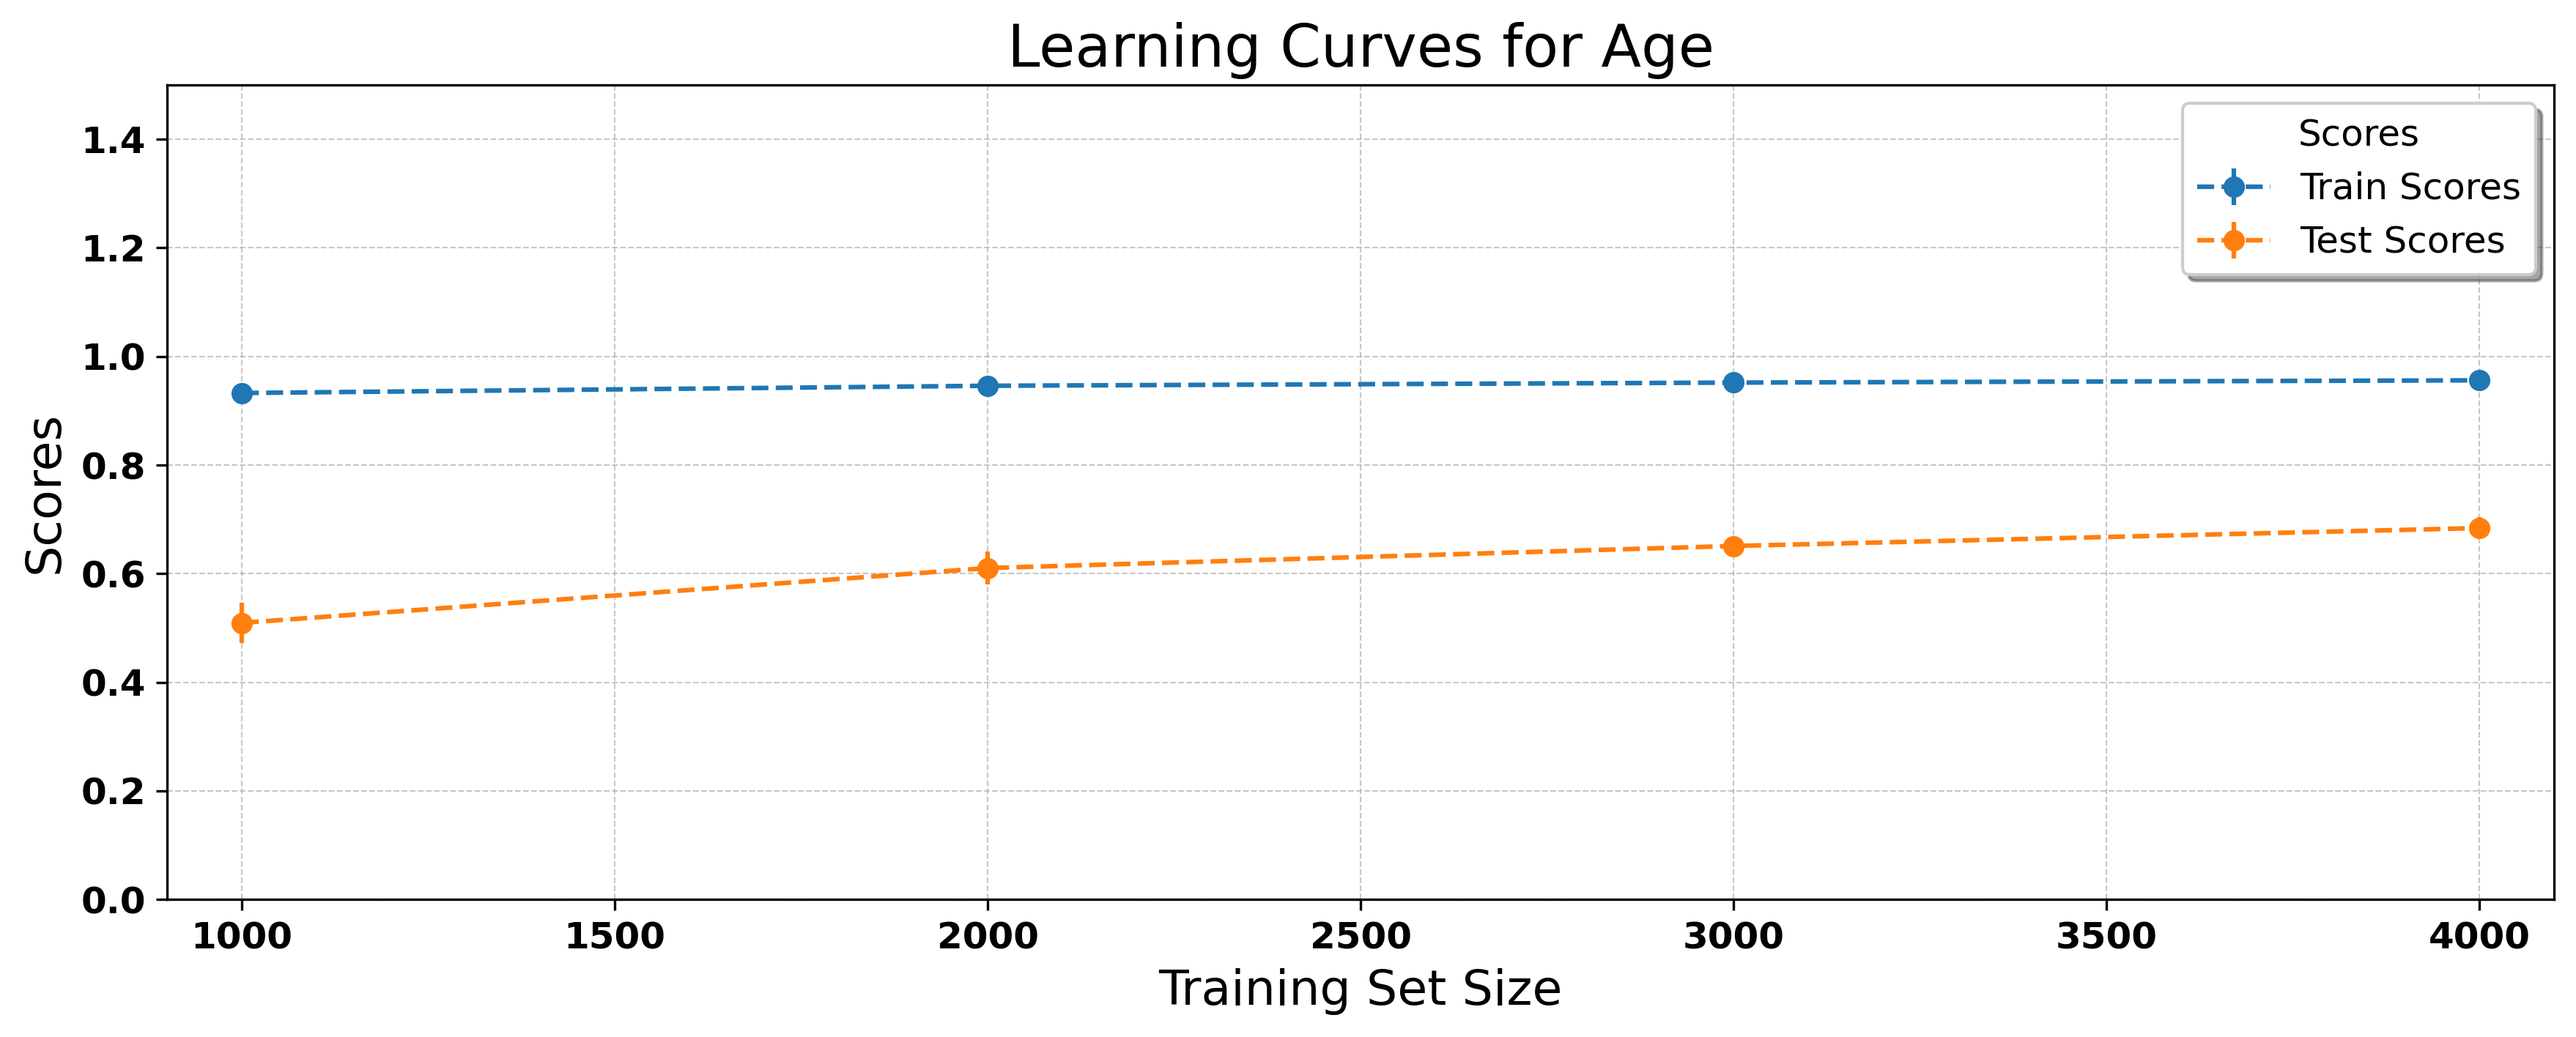

In [ ]:
# Learning Curves

trainscores=[]
trainstd=[]
testscores=[]
teststd=[]

target = df['age']
# Transform target variable
target = np.log(df['age'])

# Define training set sizes
TrainingSet = [1000, 2000, 3000, 4000]

for size in TrainingSet:
    final_features = newfeatures.iloc[0:size]
    targets = target.iloc[0:size]
    
    model = RandomForestRegressor()
    model.get_params()
    
    scores3 = cross_validate(
        model, final_features, targets, 
        cv=KFold(n_splits=5, shuffle=True, random_state=10), 
        return_train_score=True
    )
    
    testscores.append(scores3['test_score'].mean())
    teststd.append(scores3['test_score'].std())
    
    trainscores.append(scores3['train_score'].mean())
    trainstd.append(scores3['train_score'].std())



# Plot Learning Curve
plt.figure(figsize=(12, 5))
plt.title('Learning Curves for Age')
plt.xlabel('Training Set Size')
plt.ylabel('Scores')

plt.errorbar(TrainingSet, trainscores, yerr=trainstd, fmt='--o', label='Train Scores')
plt.errorbar(TrainingSet, testscores, yerr=teststd, fmt='--o', label='Test Scores')

plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.xlim(900, 4100)
plt.ylim(0.0, 1.5)

plt.legend(fontsize=12, loc='best', title='Scores', title_fontsize=12, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

### For Tau

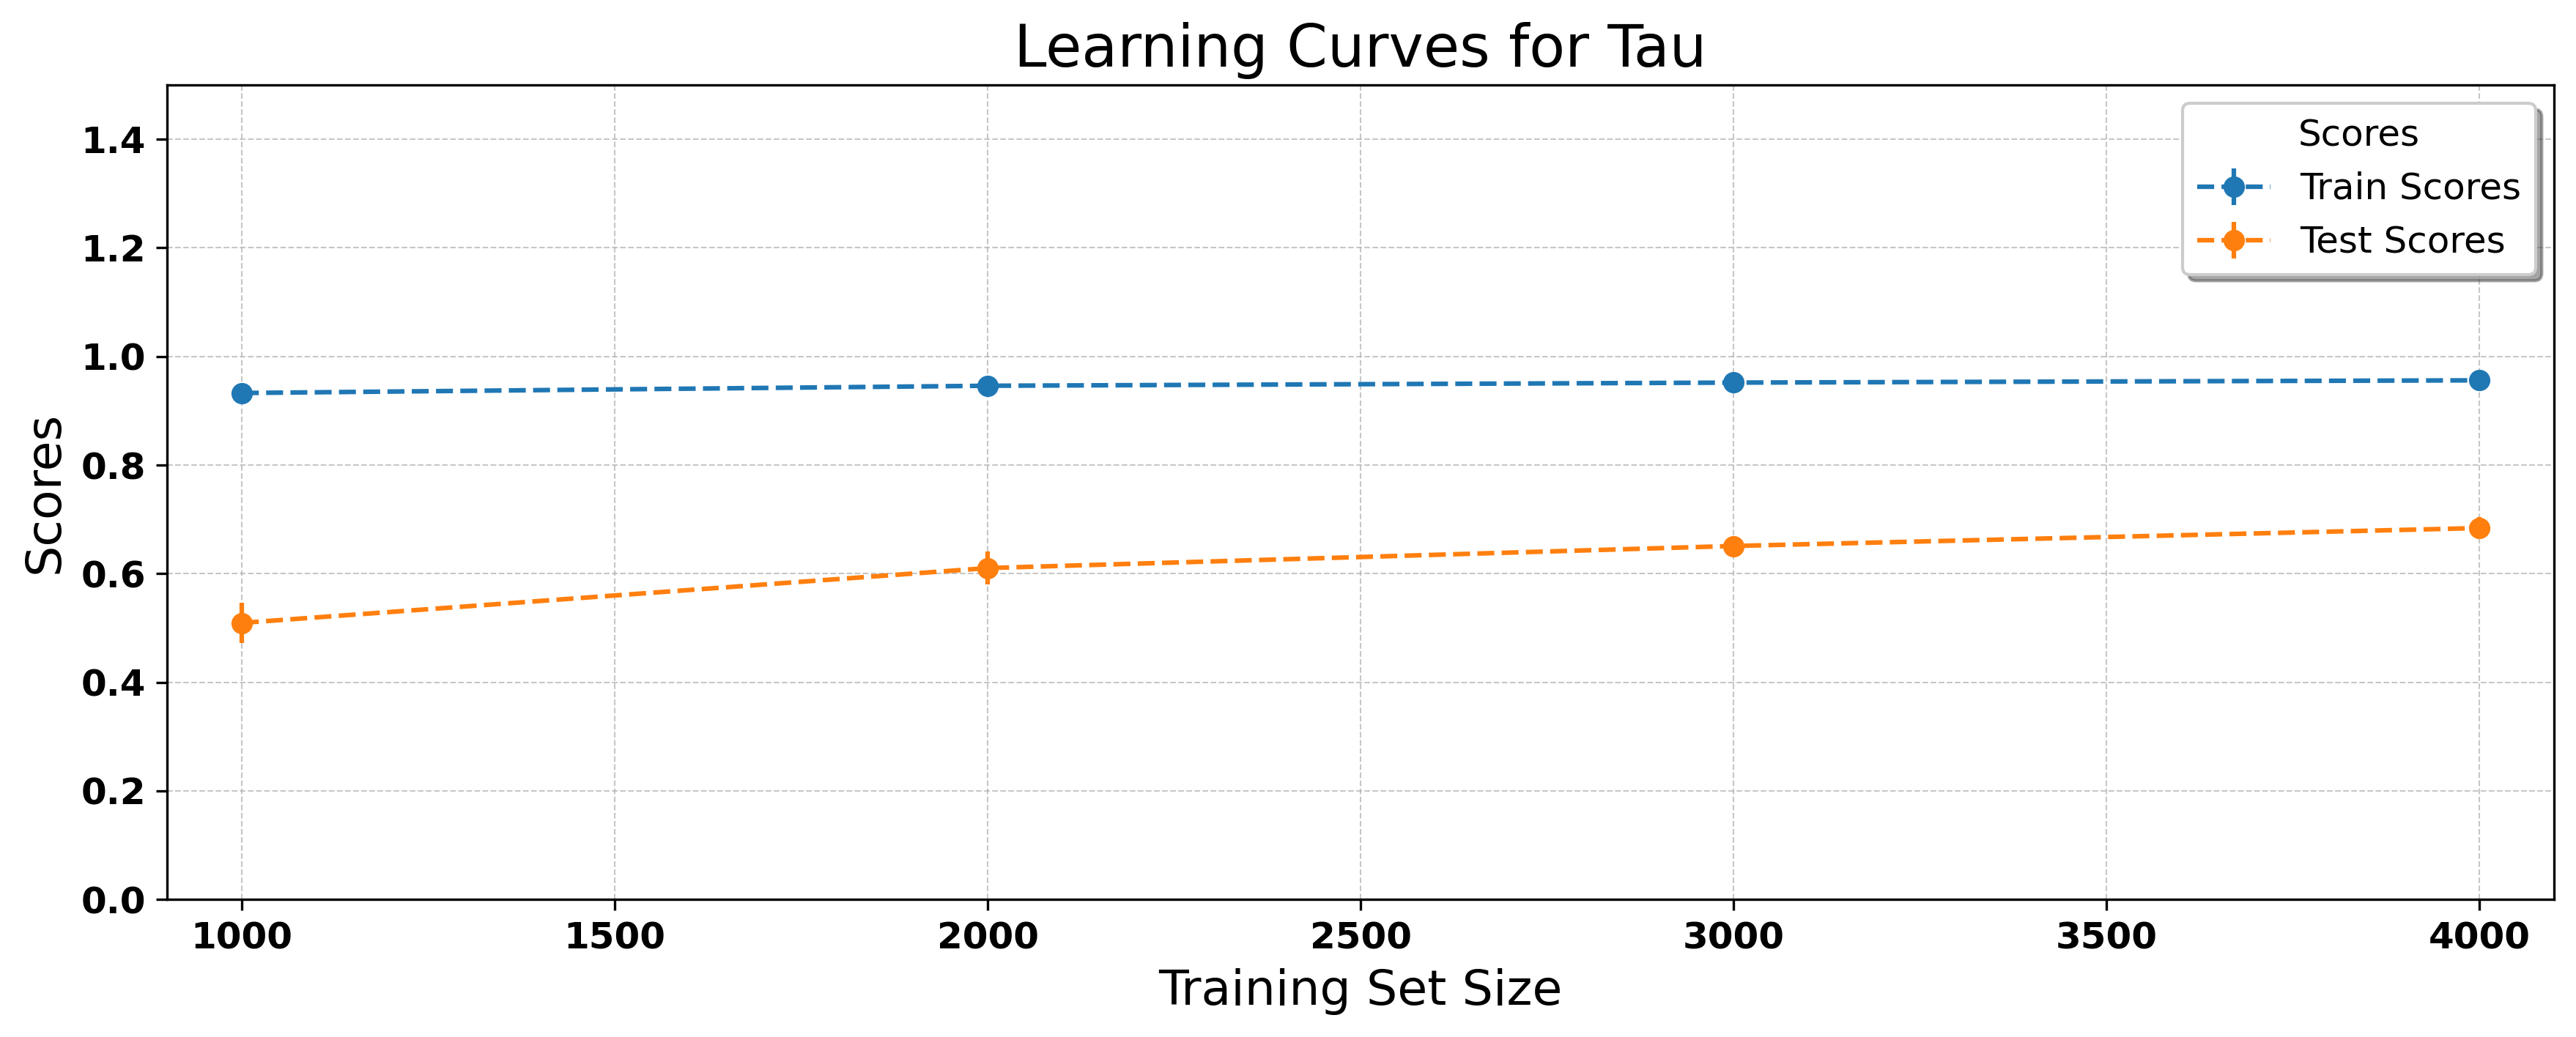

In [ ]:
#Learning Curves

trainscores=[]
trainstd=[]
testscores=[]
teststd=[]

target = df['tauGyr']
# Transform target variable
target = np.log(df['tauGyr'])

# Define training set sizes
TrainingSet = [1000, 2000, 3000, 4000]

for size in TrainingSet:
    final_features = newfeatures.iloc[0:size]
    targets = target.iloc[0:size]
    
    model = RandomForestRegressor()
    model.get_params()
    
    scores3 = cross_validate(
        model, final_features, targets, 
        cv=KFold(n_splits=5, shuffle=True, random_state=10), 
        return_train_score=True
    )
    
    testscores.append(scores3['test_score'].mean())
    teststd.append(scores3['test_score'].std())
    
    trainscores.append(scores3['train_score'].mean())
    trainstd.append(scores3['train_score'].std())


    
# Plot Learning Curve
plt.figure(figsize=(12, 5))
plt.title('Learning Curves for Tau')
plt.xlabel('Training Set Size')
plt.ylabel('Scores')

plt.errorbar(TrainingSet, trainscores, yerr=trainstd, fmt='--o', label='Train Scores')
plt.errorbar(TrainingSet, testscores, yerr=teststd, fmt='--o', label='Test Scores')

plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.xlim(900, 4100)
plt.ylim(0.0, 1.5)

plt.legend(fontsize=12, loc='best', title='Scores', title_fontsize=12, frameon=True, shadow=True)
plt.tight_layout()
plt.show()

### So it's the same with Tau. Adding data has helped!
#### Note: I tried Parameter Optimization on the new dataset too but that did not improve scores significantly

# Part 3: Feature Importance

Let's try feature ranking to understand which are the most important features contributing to the results we see.

## Important Note

Labels for  the features: The features are given by new1, new2, new3 ...new173. Where new1, new2 are the first and second features of the REDUCED dataset. New1 itself was formed by taking the average of the first 10 features, new2 the average of the next 10 features and so on from the ORIGINAL dataset.

### Feature Importance For Dust

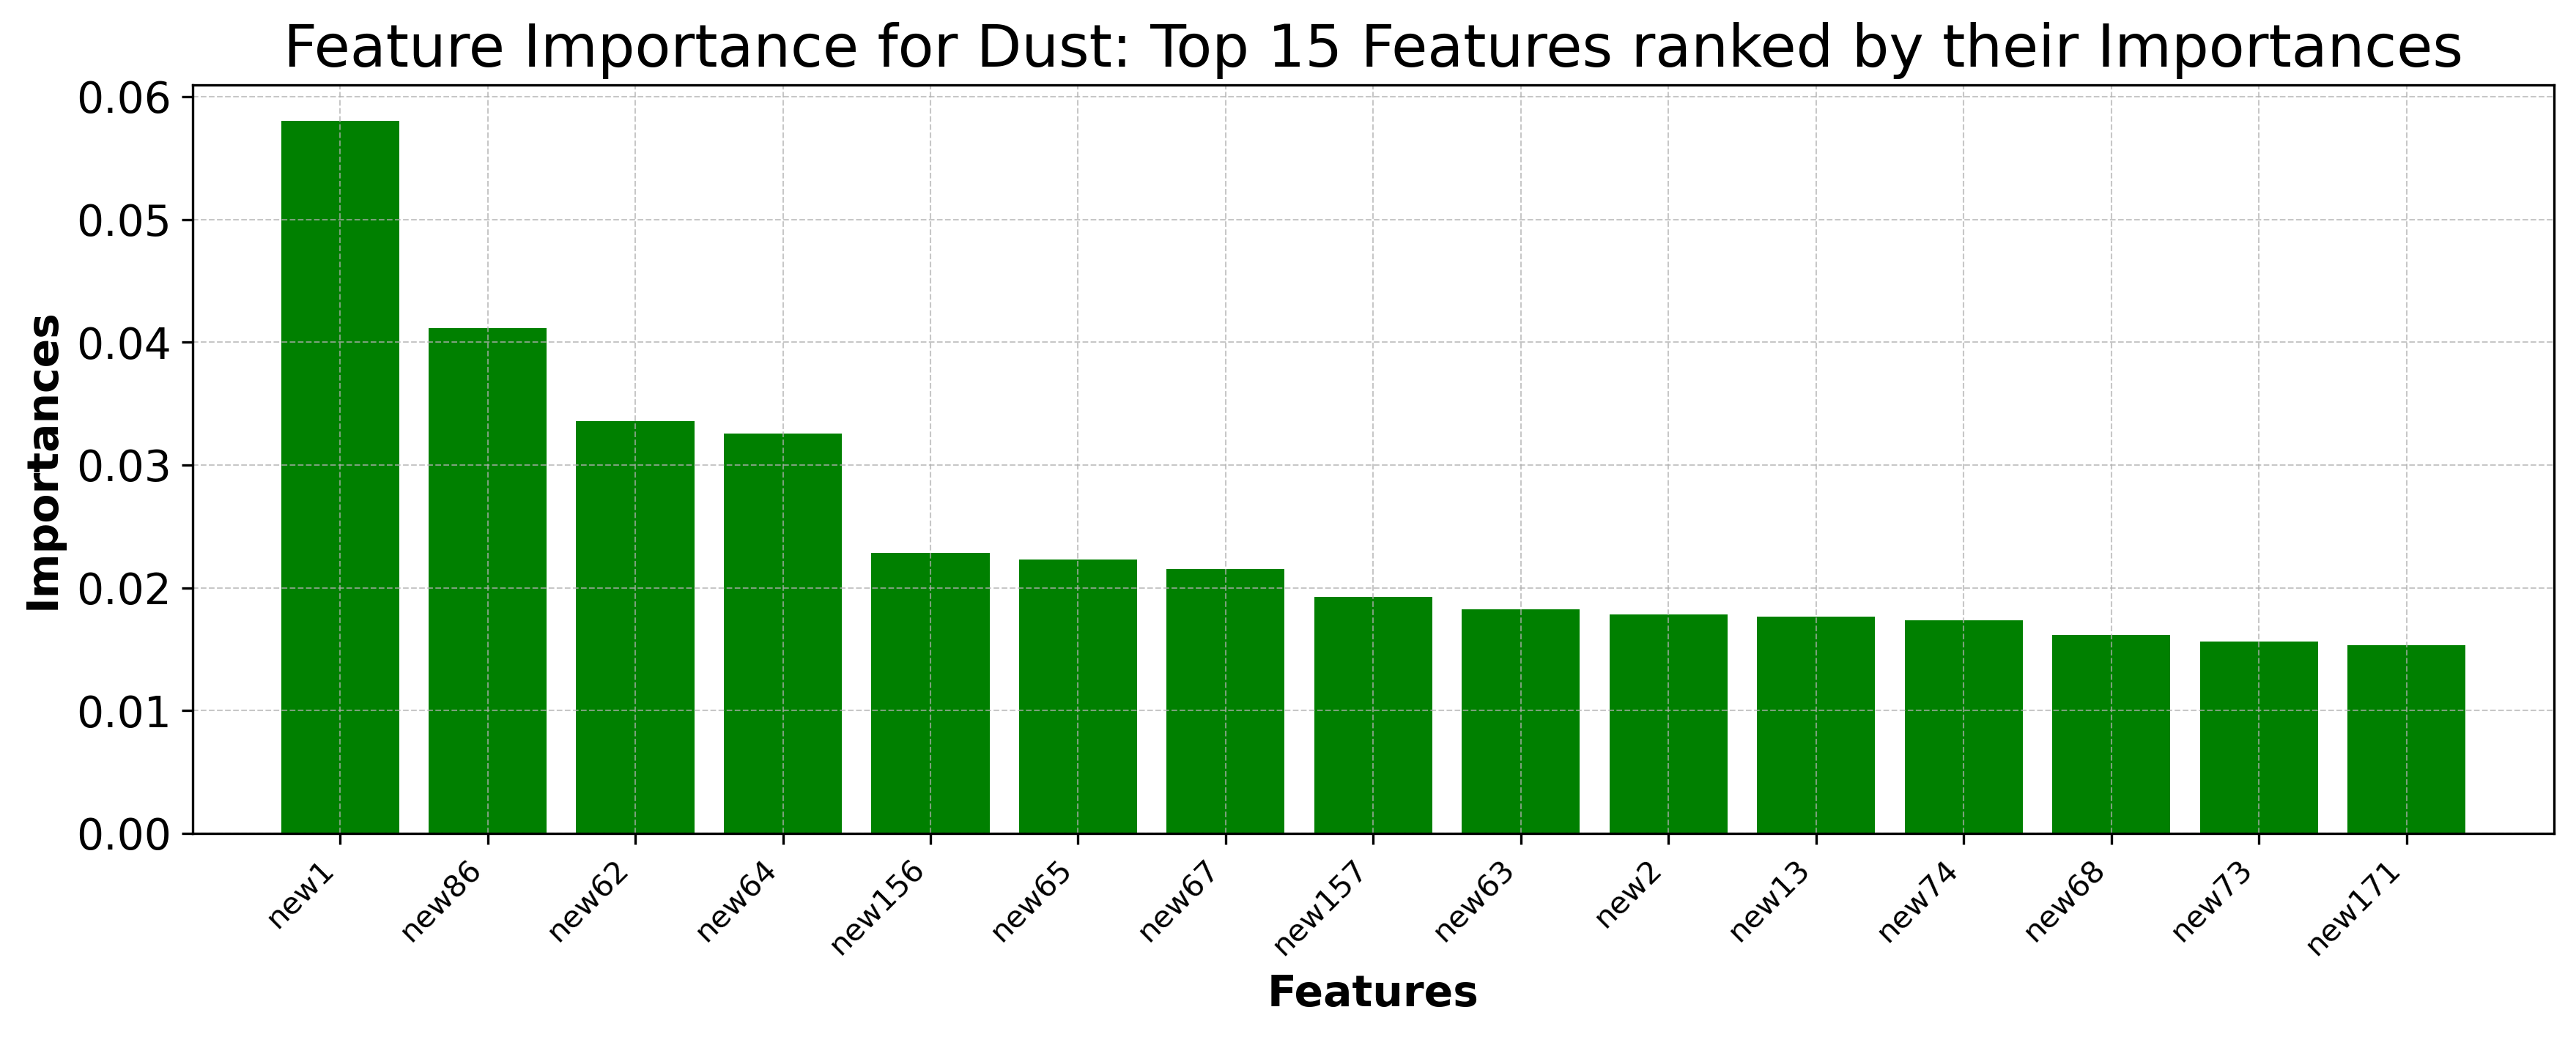

In [69]:
target = df['dust_av']
target.values.ravel() #changes shape to 1d row-like array
model = RandomForestRegressor() 
model.fit(newfeatures, target.values.ravel()) 
model.feature_importances_

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest

# Select the top 15 most important features
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = newfeatures.columns[top_indices]

plt.figure(figsize=(12, 5))  # Adjust figure size
plt.title("Feature Importance for Dust: Top 15 Features ranked by their Importances")

plt.bar(range(top_n), top_importances, color="green", align="center")

# Set x-axis labels to the top 10 features
plt.xticks(range(top_n), top_features, rotation=45, ha="right", fontsize=10)

plt.xlim([-1, top_n])
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Features', fontsize=14, weight='bold')
plt.ylabel('Importances', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

### Feature Importance For Stellar Mass

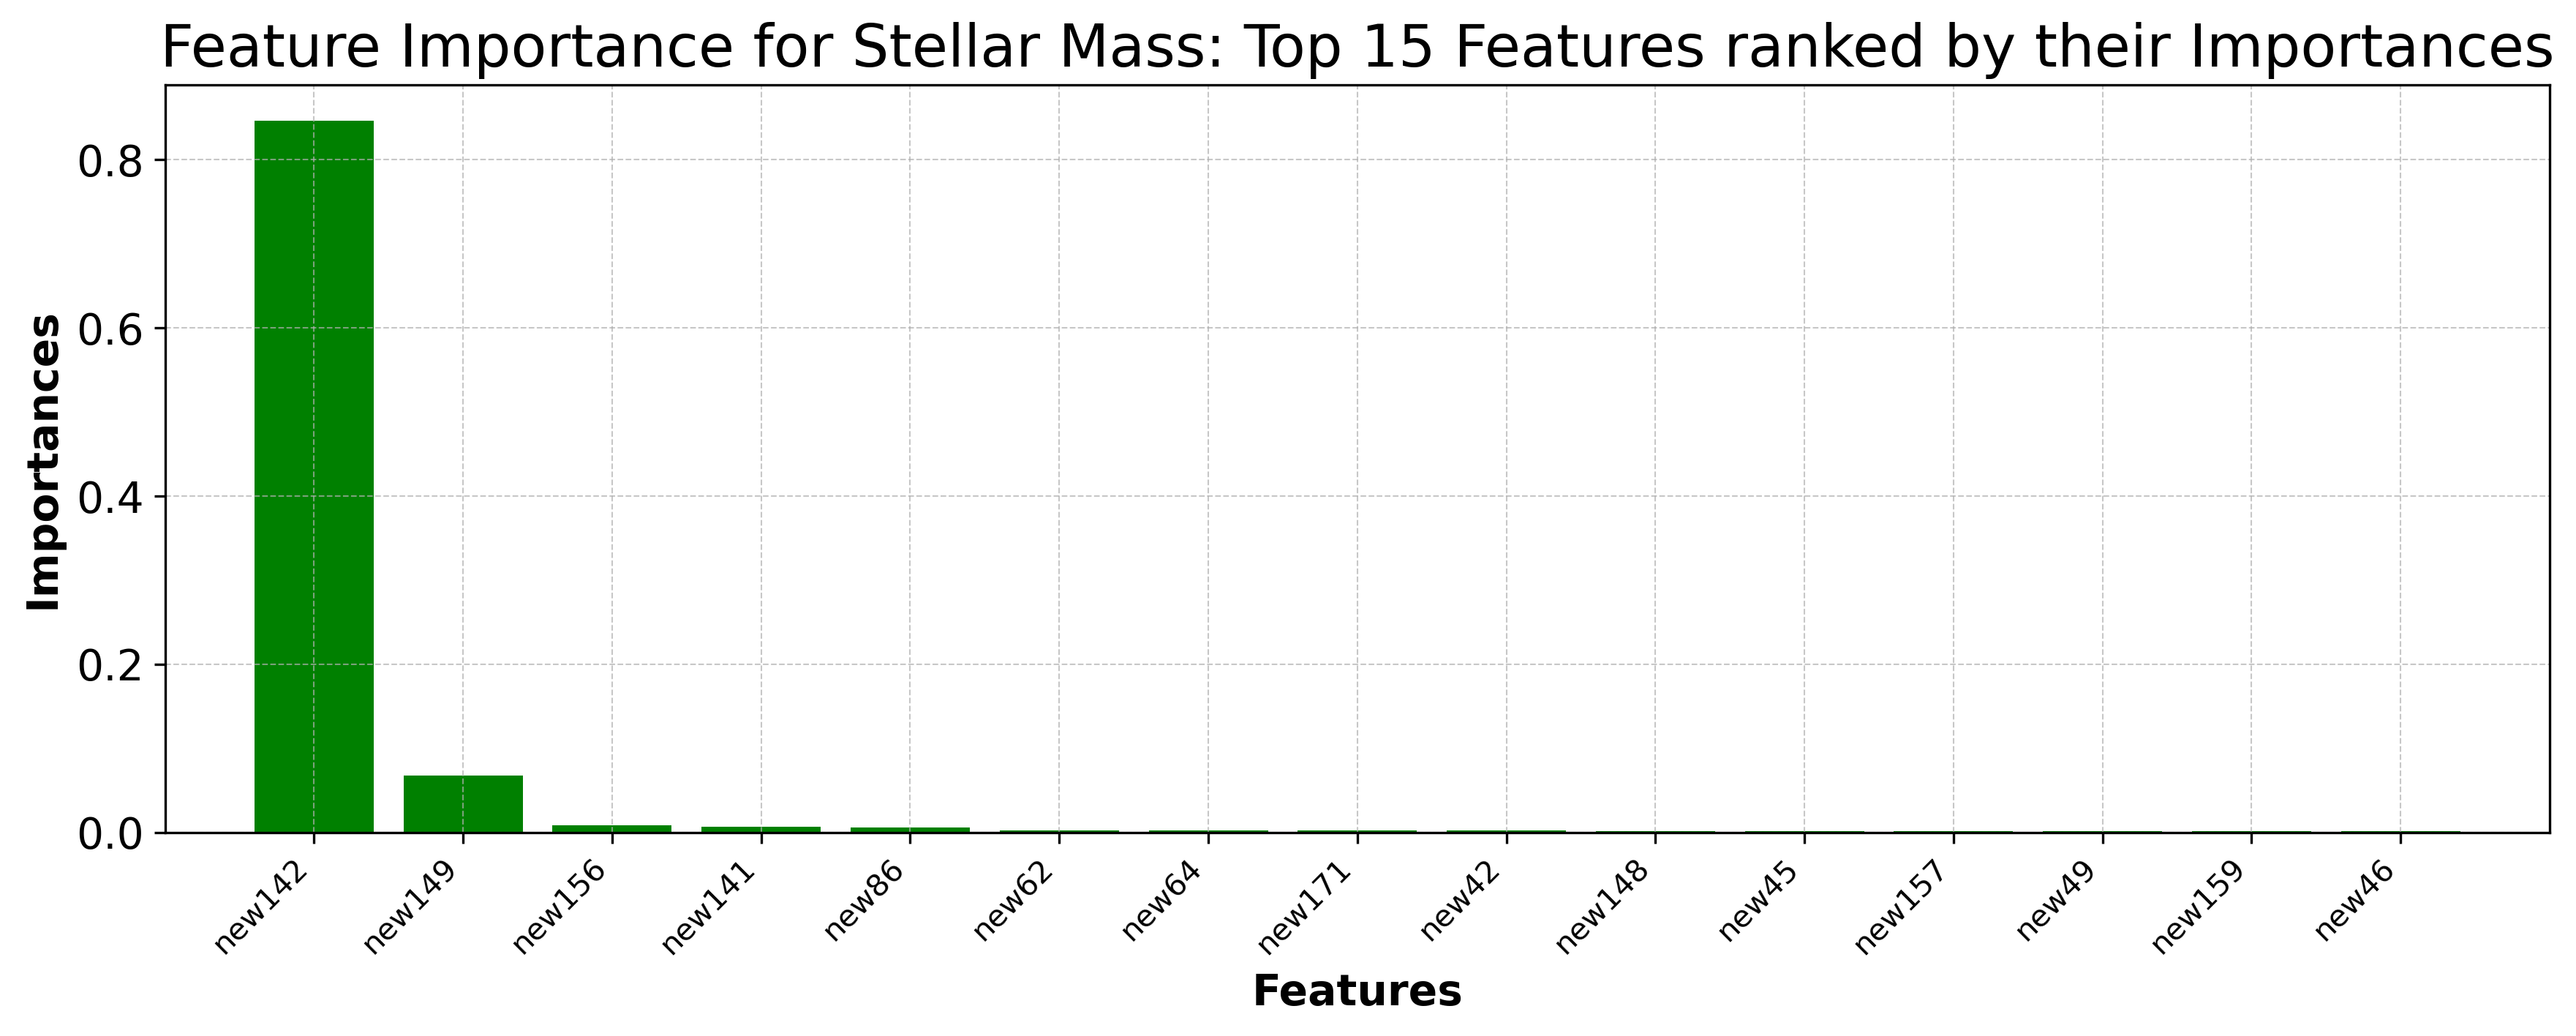

In [77]:
target = df['mass']
target.values.ravel() #changes shape to 1d row-like array
model = RandomForestRegressor() 
model.fit(newfeatures, target.values.ravel()) 
model.feature_importances_

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]


# Select the top 15 most important features
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = newfeatures.columns[top_indices]

plt.figure(figsize=(12, 5))  # Adjust figure size
plt.title("Feature Importance for Stellar Mass: Top 15 Features ranked by their Importances")

plt.bar(range(top_n), top_importances, color="green", align="center")

# Set x-axis labels to the top 10 features
plt.xticks(range(top_n), top_features, rotation=45, ha="right", fontsize=10)

plt.xlim([-1, top_n])
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Features', fontsize=14, weight='bold')
plt.ylabel('Importances', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

## Feature Importance for Age and Tau

Because there are variance issues for age and tau so feature importance with the best scores can not necessarily be relied upon, but let's do them anyways.

### Feature Importance For Age

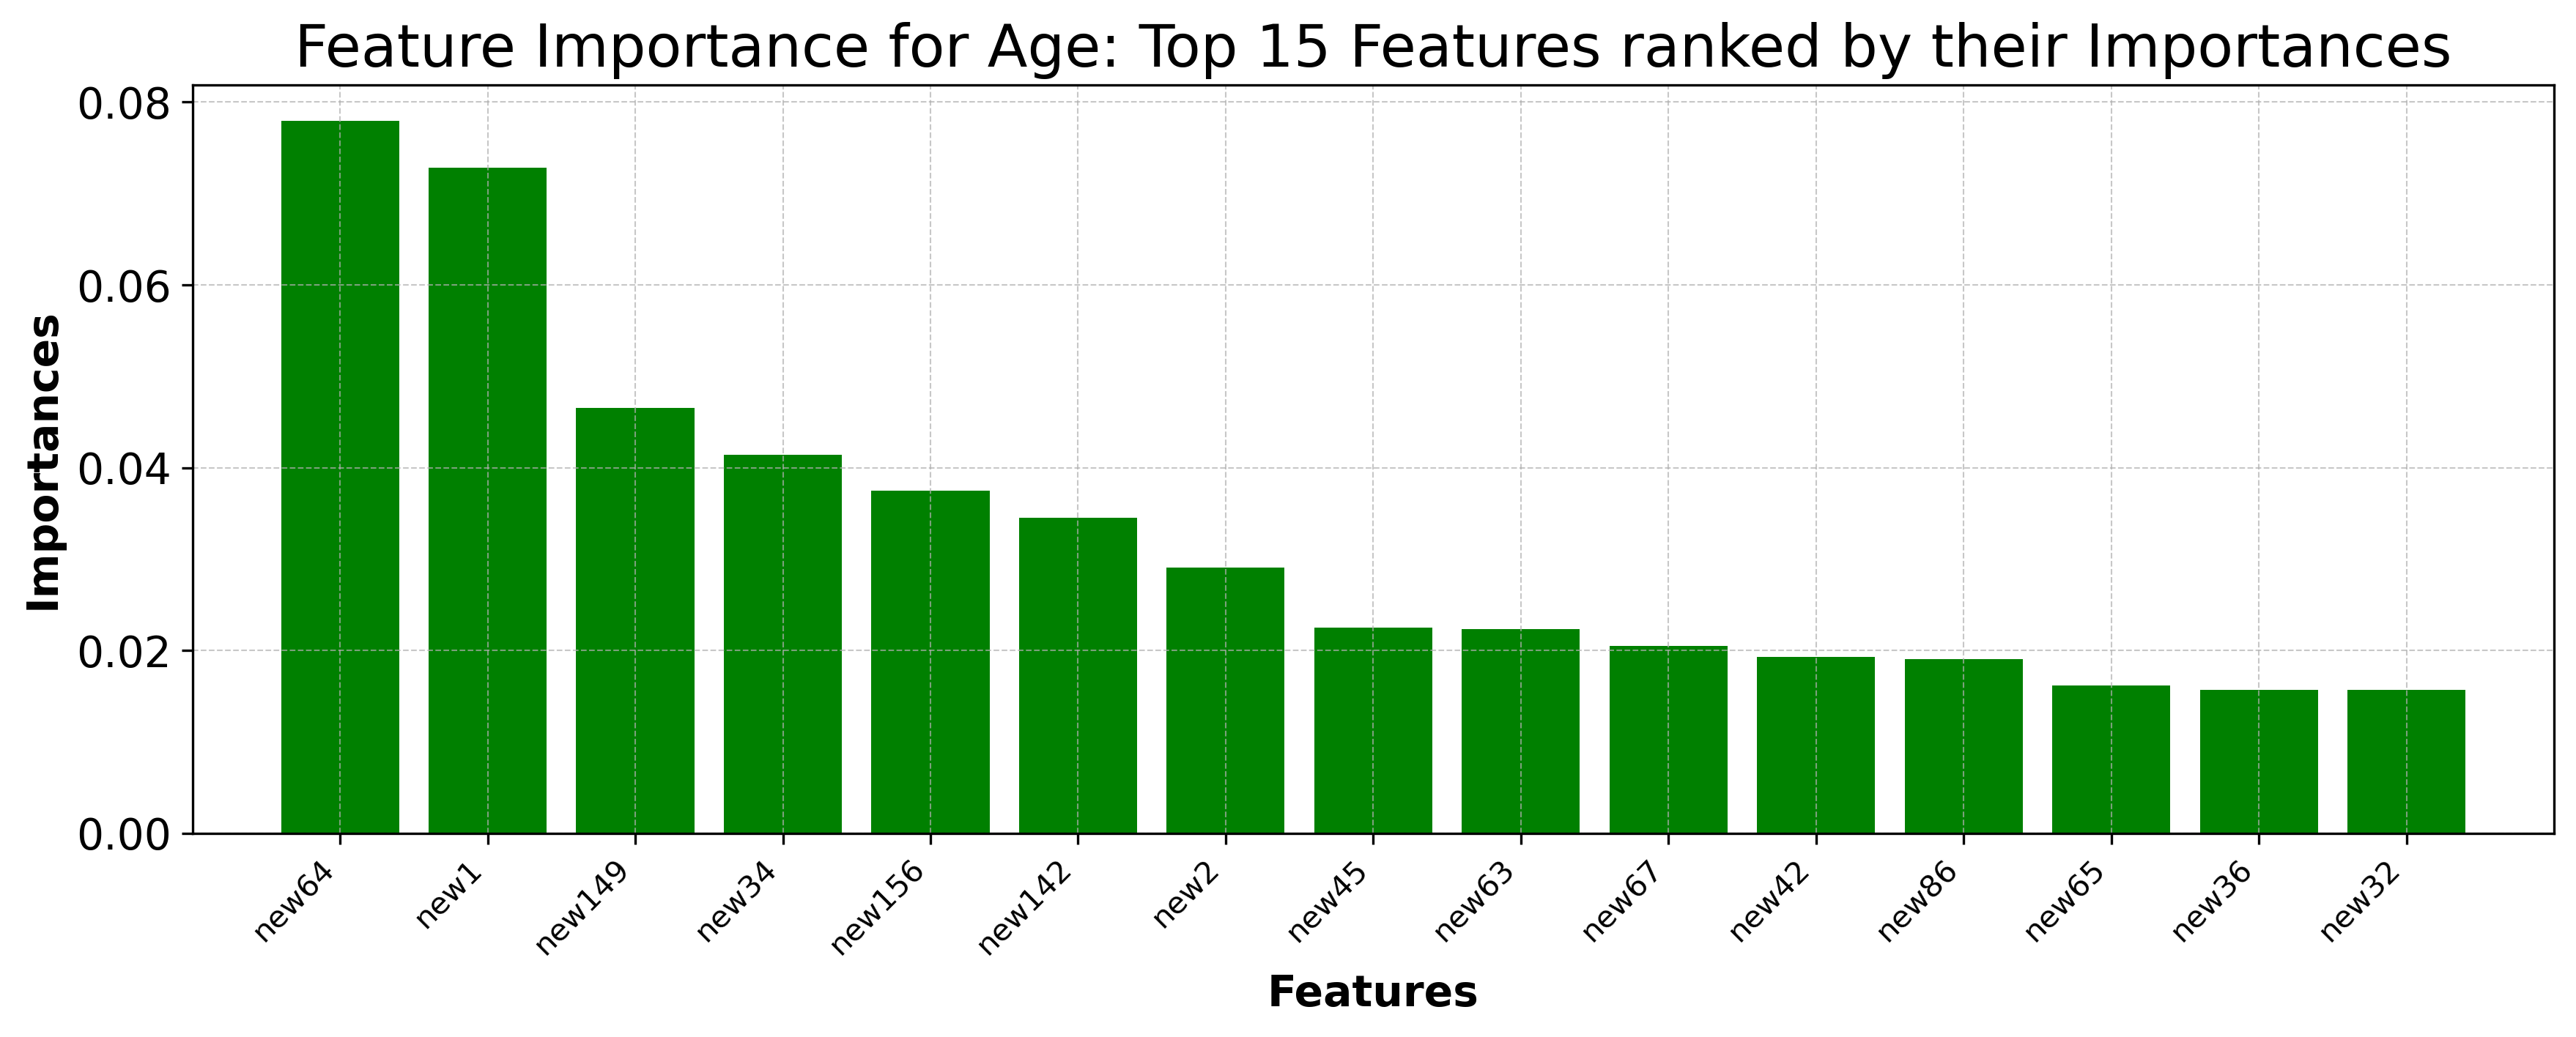

In [78]:
target = df['age']
target.values.ravel() #changes shape to 1d row-like array
model = RandomForestRegressor() 
model.fit(newfeatures, target.values.ravel()) 
model.feature_importances_

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = newfeatures.columns[top_indices]

plt.figure(figsize=(12, 5))  # Adjust figure size
plt.title("Feature Importance for Age: Top 15 Features ranked by their Importances")

plt.bar(range(top_n), top_importances, color="green", align="center")

# Set x-axis labels to the top 10 features
plt.xticks(range(top_n), top_features, rotation=45, ha="right", fontsize=10)

plt.xlim([-1, top_n])
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Features', fontsize=14, weight='bold')
plt.ylabel('Importances', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

### Feature Importance For Tau

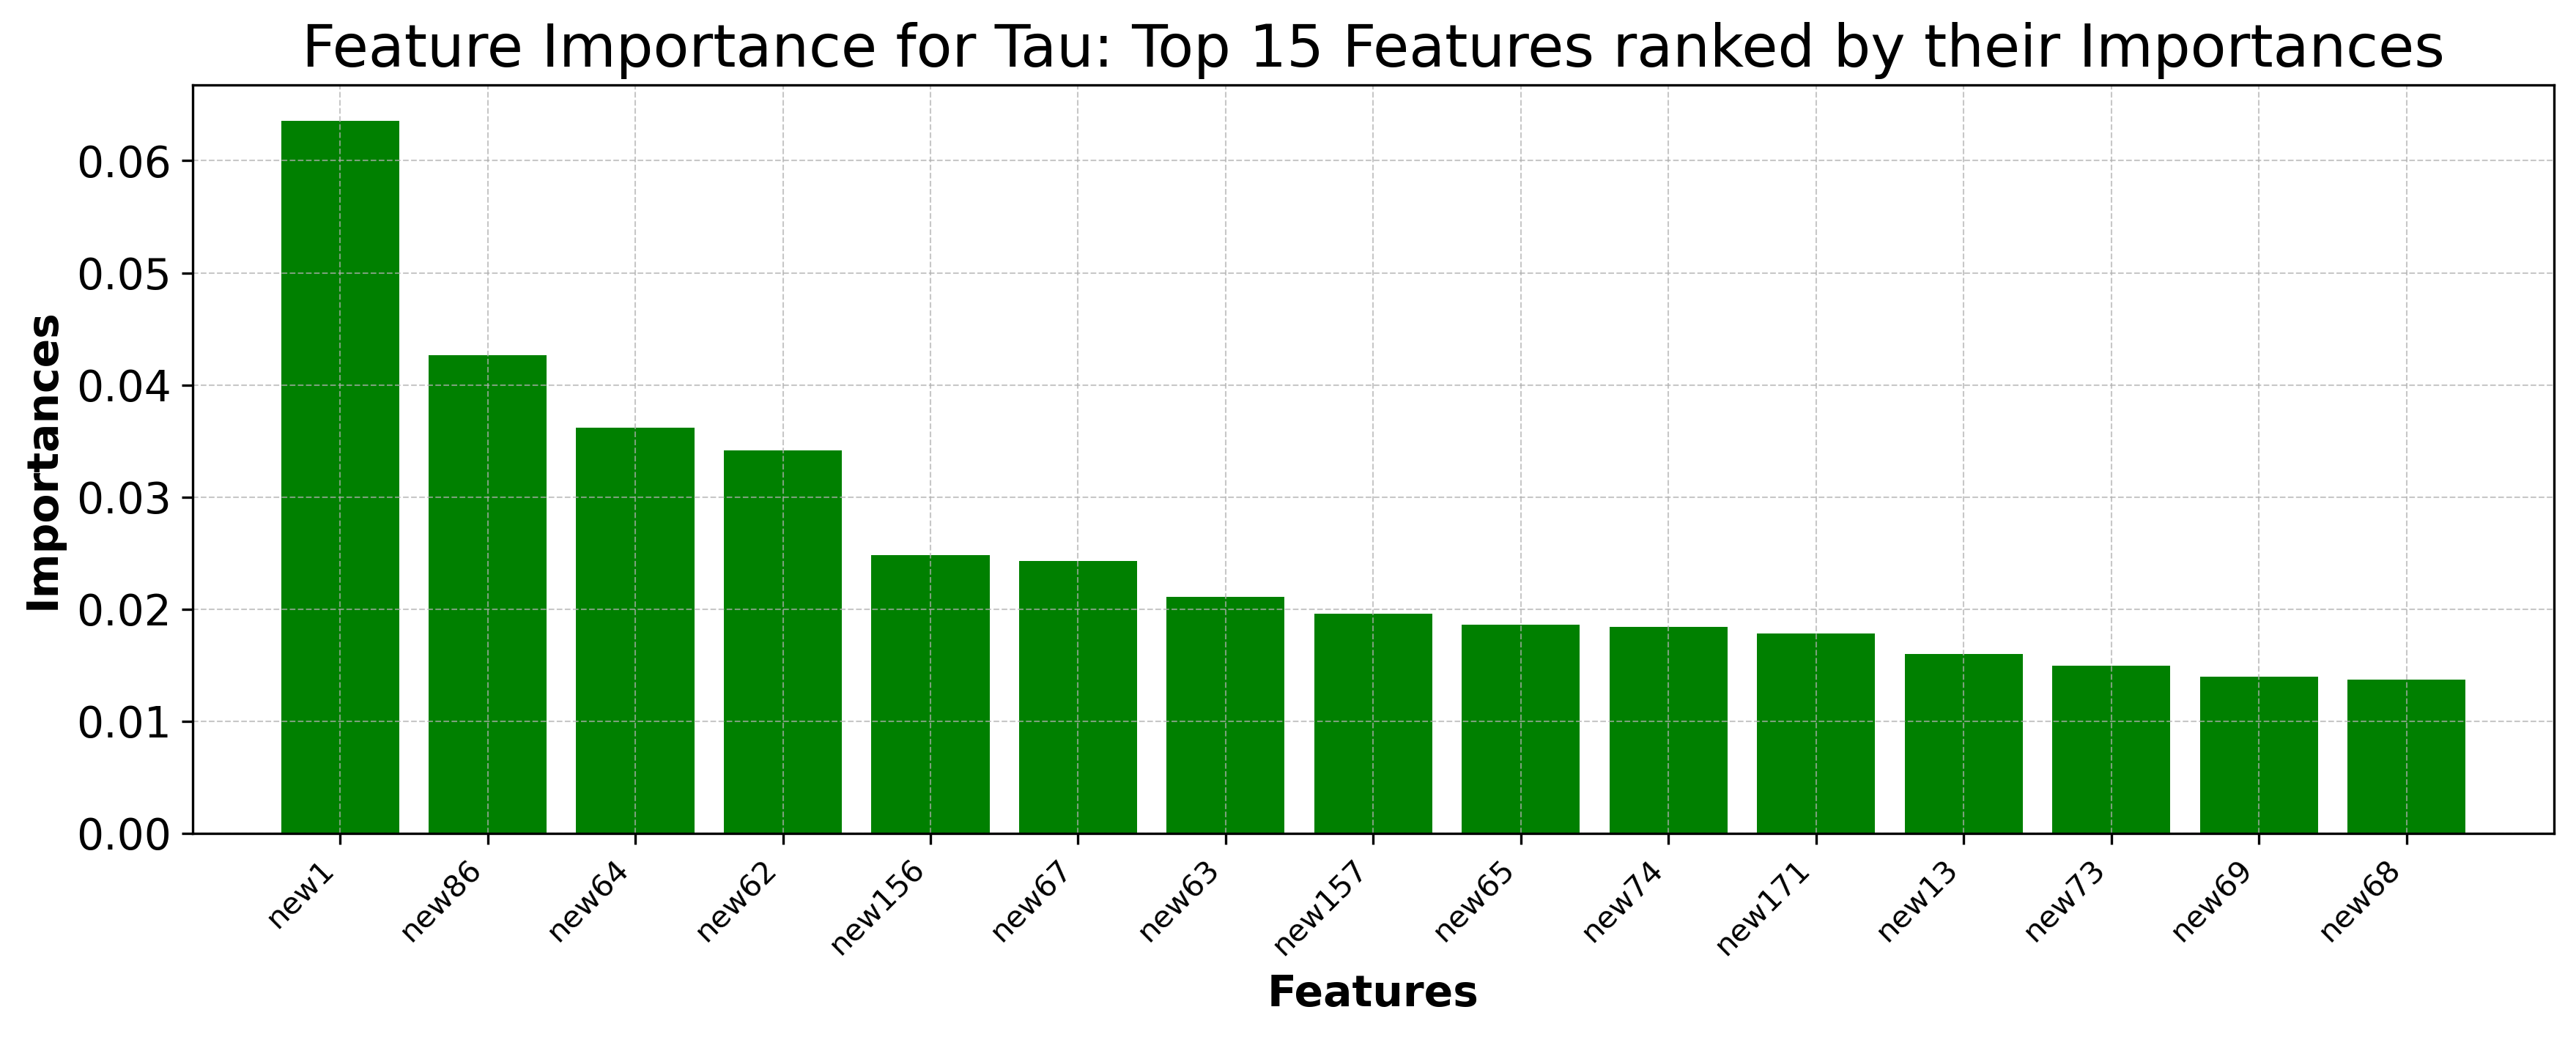

In [79]:
target = df['tauGyr']
target.values.ravel() #changes shape to 1d row-like array

model = RandomForestRegressor() 
model.fit(newfeatures, target.values.ravel()) 
model.feature_importances_

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest

top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = newfeatures.columns[top_indices]

plt.figure(figsize=(12, 5))  # Adjust figure size
plt.title("Feature Importance for Tau: Top 15 Features ranked by their Importances")

plt.bar(range(top_n), top_importances, color="green", align="center")

# Set x-axis labels to the top 10 features
plt.xticks(range(top_n), top_features, rotation=45, ha="right", fontsize=10)

plt.xlim([-1, top_n])
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xlabel('Features', fontsize=14, weight='bold')
plt.ylabel('Importances', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

### Interesting that a few features seem to dominate the results especially for Stellar Mass

# Summary of Results and Takeaways


1. Using the mean of every ten features reduced the dataset size by a factor of 10 while still preserving the results.

2. We were able to predict with some confidence, the amount of Dust and Stellar Mass from the data using Random Forests. Why? Likely because these quantities have a direct correlation with the spectrum. Dust tends to absorb light in the low wavelengths like UV and radiate some of this in the infrared thereby shaping the spectrum overall. It also reduces the overall brightness of the spectrum. Stellar mass is inherently related to stellar luminosity. For a given mass to light ratio more mass corresponds to more light and vice-versa. So looking at the spectrum gives us a sense of the overall luminosity and hence the underlying mass.  


3. Age and Tau are much trickier. A galaxy appearing red does not necessarily need to be older. Both a young galaxy with a lot of dust and an older galaxy might have a similar spectrum. It's not obvious how Tau should affect the specstrum as whole. 

4. By Feature engineering, working with the logarithm of the output targets Age and Tau, the results were improved dramatically. One of the things that I tried was to have the amount of dust as a feature while trying to predict the age because of the above mentioned affect of dust on the redness of the galaxy. But alas this did not work.

5. Results Scores improved a bit by doubling the size of the data set. 

6. Quite surprised by the feature importance results. Expected the importance of features to be split more or less uniformly between the features for Stellar Mass and Dust, instead found 2-3 features dominated the results. 



#  Improvements and Considerations


- Test Scores and Variance issues for Tau and Age can still be improved, perhaps adding more Data can further improve results by about 10%.
- Why do few features dominate the results?
- We could do more feature engineering and combine features or take ratios and then check if there are improvements.
- We could also explore other Machine Learning algorithms. Would be interesting to try SVM and boosting methods on the same problem and then finally Neural Networks as well. Lasso Regression also seems like a good idea for this problem because of the large number of features and Lasso's inherent ability to set the coefficients of uninmportant features to zero.